# Logistic Regression Analysis - Bank Loan Customer Classification

# Submitted by Charles Kilpatrick


# February 19, 2023


## Background and Context:

AllLife Bank is a US bank with an expanding customer base. The majority of these customers are liability customers (depositors) with varying account balances. A small minority of customers are also borrowers (asset customers) and the bank needs to  expand this base rapidly to bring in more loan business and earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

The model presented below is intended to assist the marketing department identify potential customers who have a higher probability of purchasing a loan.

## Study Objectives:

To predict whether a liability customer will buy a personal loan or not.
Determine which variables are most significant.
Determine which segment of customers should be targeted more.

## Conclusions:

The most important variables for determining whether an individual will take a loan are: Income (0.39), Education (0.38), Family (0.16), CCAvg (0.04), CD_Account (0.02), and Age (0.01).

The F1 score was used as the key score for this imbalanced data set as it accounts for both recall and precision. Keying only on recall in this analysis could potentially result in selecting a model with relatively low precison. This could result in using company resources on an excess number of false positives.  

The best performing model for determining if an individual will take a loan is a Decision Tree with post-pruning.  Logistic regression was not as effective.  Utilization of the precision recall optimal threshold of 0.337 resulted in the best performing logistic regression model. A comparison of the model test set results is:

Decision Tree (post-pruning)
Test Accuracy:  0.99
Test Recall:    0.91
Test Precision: 0.96
Test F1:        0.93


Logistic Regression (optimal precision recall threshold 0.337)
Test Accuracy:  0.95
Test Recall:    0.71
Test Precision: 0.75
Test F1:        0.73



## Actionable Insights and Recommendations:

Concentrate marketing efforts on the higher income population segment who are more likely to take loans.

It was noted that individuals with greater educational attainment are more likely to take loans.  The bank should reach out to medical, legal, and other professional organizations to solicit clients for loans.

County of residence had almost no correlation with loan holders. The bank should concentrate marketing efforts in more affluent counties, such as Orange County to solicit customers.

## Data Dictionary:

ID: Customer ID
Age: Customer’s age in completed years
Experience: #years of professional experience
Income: Annual income of the customer (in thousand dollars)
ZIP Code: Home Address ZIP code.
Family: the Family size of the customer
CCAvg: Average spending on credit cards per month (in thousand dollars)
Education: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
Mortgage: Value of house mortgage if any. (in thousand dollars)
Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
Securities_Account: Does the customer have securities account with the bank?
CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
Online: Do customers use internet banking facilities?
CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?

## Loading Libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)

# %load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# To build model for prediction

from sklearn.linear_model import LogisticRegression

#For decision tree pruning
from sklearn.model_selection import GridSearchCV


# To get diferent metric scores

from sklearn import metrics

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

#    plot_confusion_matrix,

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree




In [2]:
# Import Scaler libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# Function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [4]:
# Install mlxtend
#!pip install mlxtend

In [5]:
# Import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [6]:
# Install uszipcode
#!pip install uszipcode

In [7]:
# Upgrade uszipcode
#!pip install --upgrade uszipcode

In [8]:
# Import SearchEngine
from uszipcode import SearchEngine

In [9]:
#Display full dataframe information (Non-turncated Text column.)
pd.set_option('display.max_colwidth', None)

Load data

In [10]:
# Import data
data = pd.read_csv("Loan_Modelling.csv")

In [11]:
# copying data to another dataframe to avoid any changes to original data
df = data.copy()

Understand the dataset shape and datatypes

In [12]:
# Dataframe shape
df.shape

(5000, 14)

In [13]:
# Dataframe informational check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [14]:
# Display first 5 rows
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [15]:
# Display last 5 rows
df.tail()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


In [16]:
# Establish consistent random sampling
np.random.seed(1)
df.sample(10)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
2764,2765,31,5,84,91320,1,2.9,3,105,0,0,0,0,1
4767,4768,35,9,45,90639,3,0.9,1,101,0,1,0,0,0
3814,3815,34,9,35,94304,3,1.3,1,0,0,0,0,0,0
3499,3500,49,23,114,94550,1,0.3,1,286,0,0,0,1,0
2735,2736,36,12,70,92131,3,2.6,2,165,0,0,0,1,0
3922,3923,31,4,20,95616,4,1.5,2,0,0,0,0,1,0
2701,2702,50,26,55,94305,1,1.6,2,0,0,0,0,1,0
1179,1180,36,11,98,90291,3,1.2,3,0,0,1,0,0,1
932,933,51,27,112,94720,3,1.8,2,0,0,1,1,1,1
792,793,41,16,98,93117,1,4.0,3,0,0,0,0,0,1


In [17]:
# Check for null values
df.isnull().sum().sort_values(ascending=False)

ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

In [18]:
# Check for duplicated values
df.duplicated().sum()

0

In [19]:
# Display dataframe description
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


## Univariate Analysis

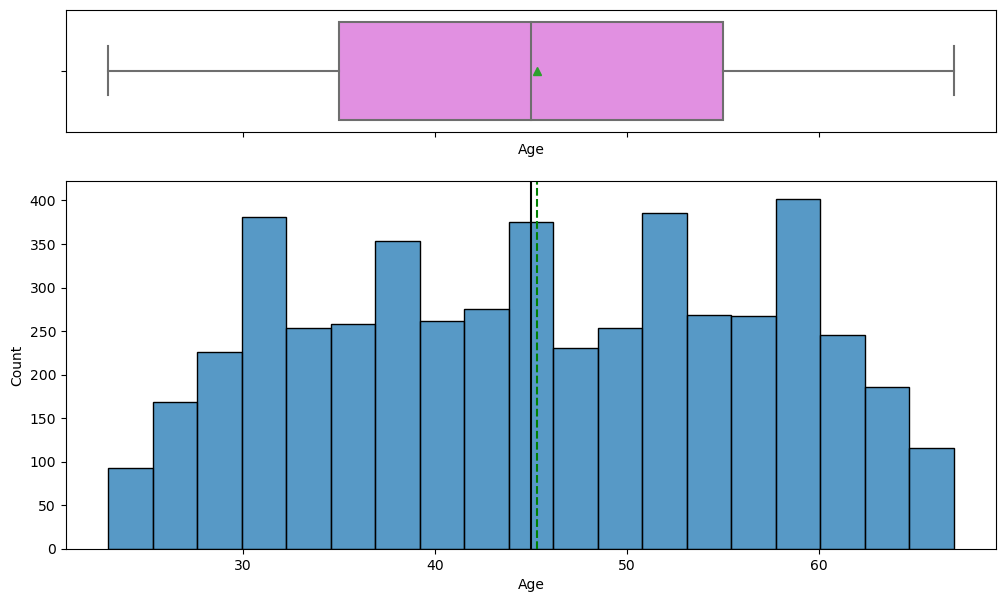

In [20]:
# Histogram and boxplot of age variable
histogram_boxplot(df, "Age")

### Observations

- Median age is 45 with a relatively normal distribution.  There are no outliers for this variable.

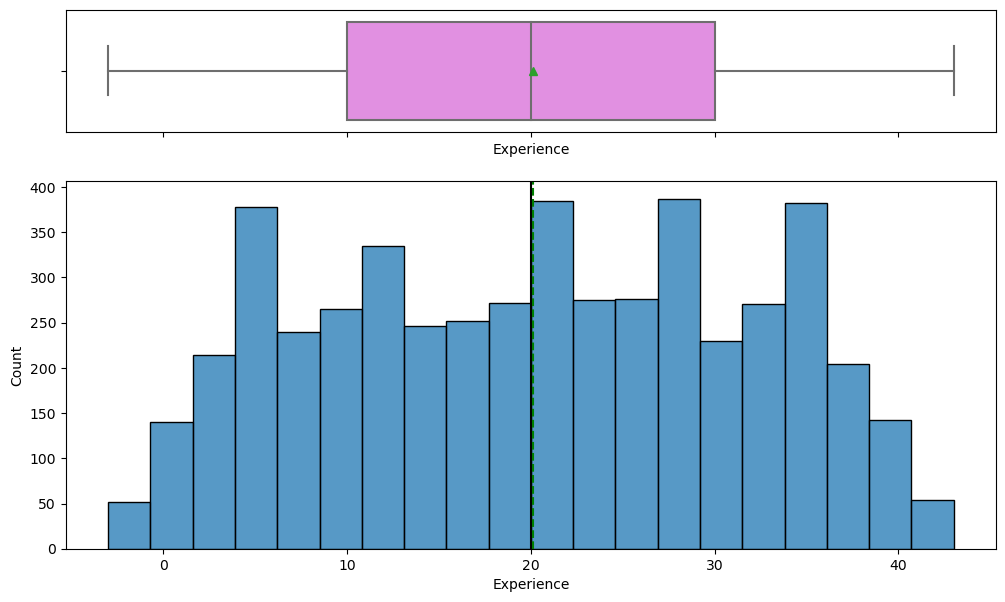

In [21]:
# Histogram and boxplot of experience
histogram_boxplot(df, "Experience")

### Observations

- Median experience is 20 and the data has a reasonably normal distribution.  Later data analysis will find that this variable
  is highly correlated with age and the experience parameter will be deleted from the dataframe

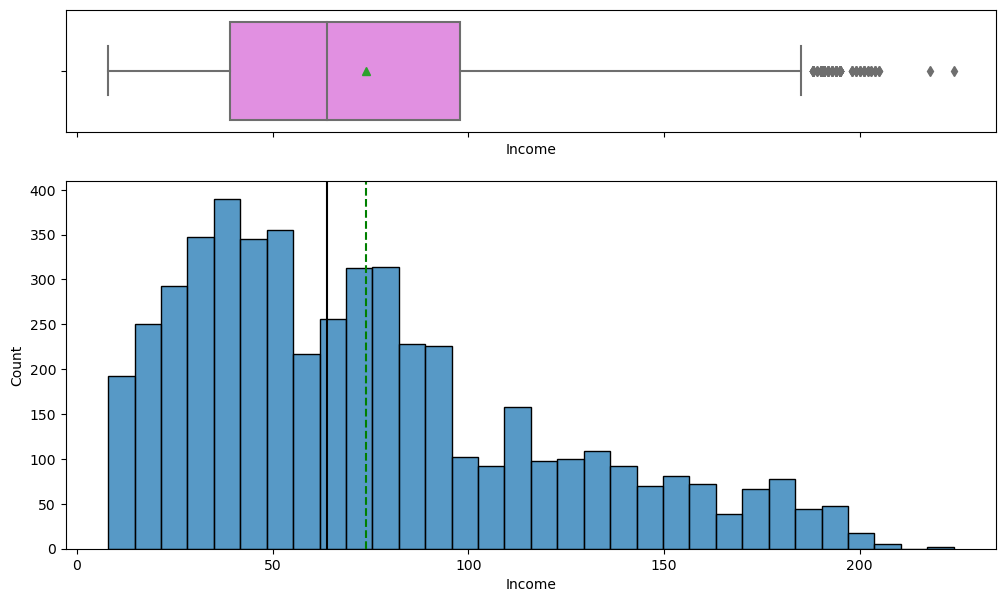

In [22]:
# Histogram and boxplot of income
histogram_boxplot(df, "Income")

### Observations

- Median income is 64 and the data is right skewed with outliers.  This appears to be a reasonable income distribution with
  lesser numbers of higher income individuals. No outlier treatment will be applied.  The higher income outlier data is useful   for modelling. 

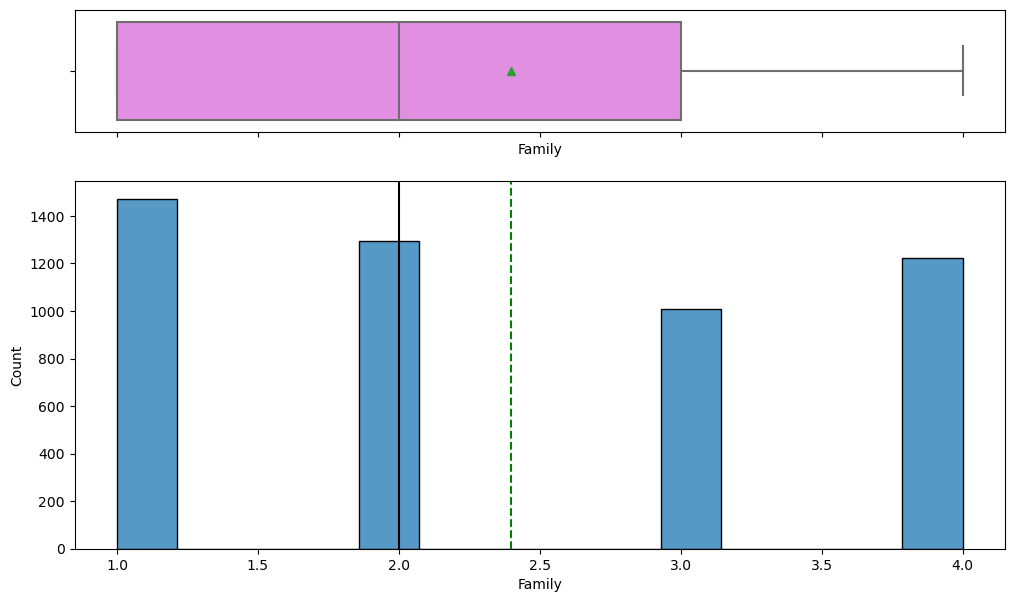

In [23]:
# Histogram and boxplot of family
histogram_boxplot(df, "Family")

### Observations

- The median for family is 2 and this data has no outliers.

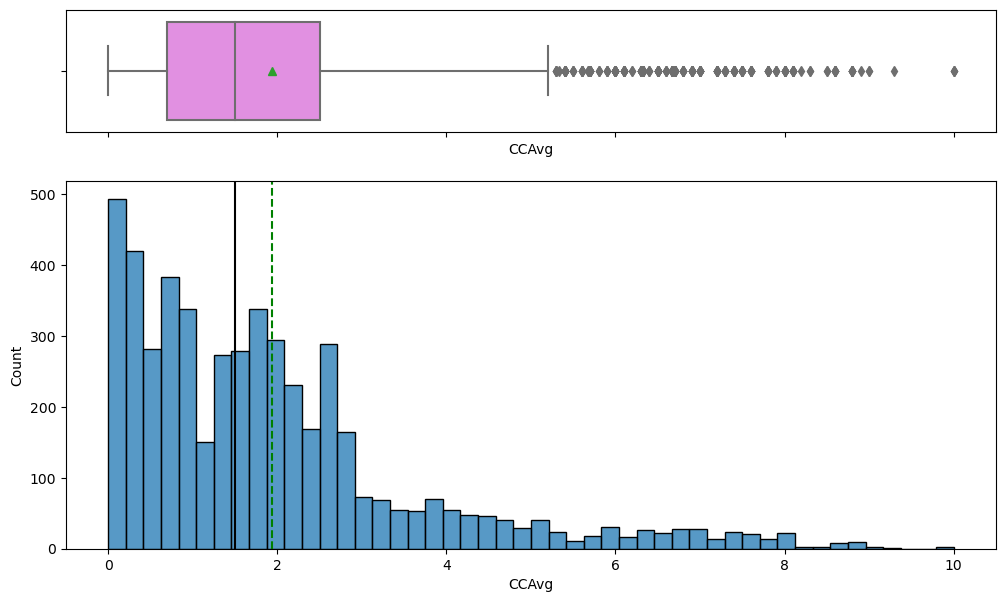

In [24]:
# Histogram and boxplot of CCAvg
histogram_boxplot(df, "CCAvg")

### Observations

- CCAvg data is right skewed as would be expected with lower numbers of individuals represented as balances increase. No
  outlier treatment will be applied as the number of individulas would be expected to decline with increased credit card
  balances.

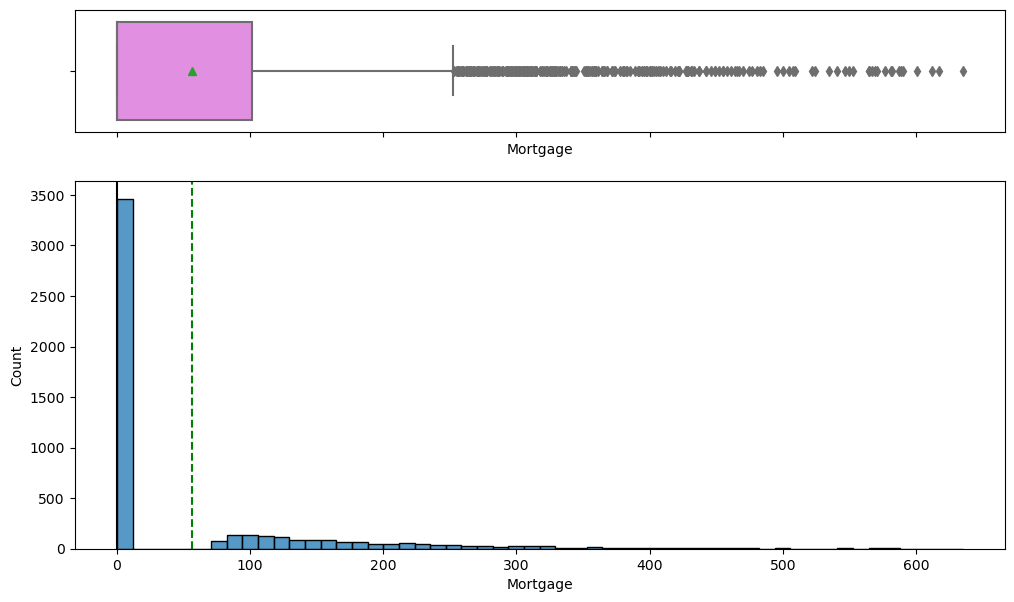

In [25]:
# Histogram and boxplot of mortgage
histogram_boxplot(df, "Mortgage")

### Observations

- The median value for mortgage is zero which may be either individuals who own a home or are renting. The data is right skewed
  which is people who do own a home and have a mortgage.  There will be no treatment for the high end outliers as these
  mortgage levels are not unusual and will be valid data for modelling.

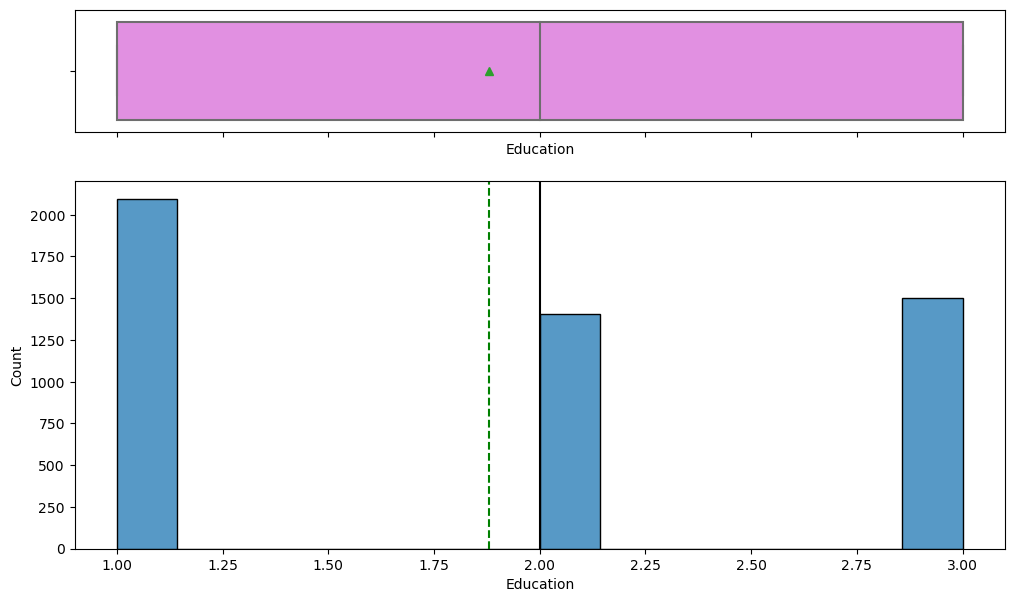

In [26]:
# Histogram and boxplot of education
histogram_boxplot(df, "Education")

### Observations

- The median value of education is 2 which indicates graduate studies.  This dataset represents a population of relatively well
  educated people as this is well above the median education of the general population of the United States. The modal value is   1 which is undergraduate education.

### Plot vertical boxplots to better visualize outliers.  There is no outlier treatment required.

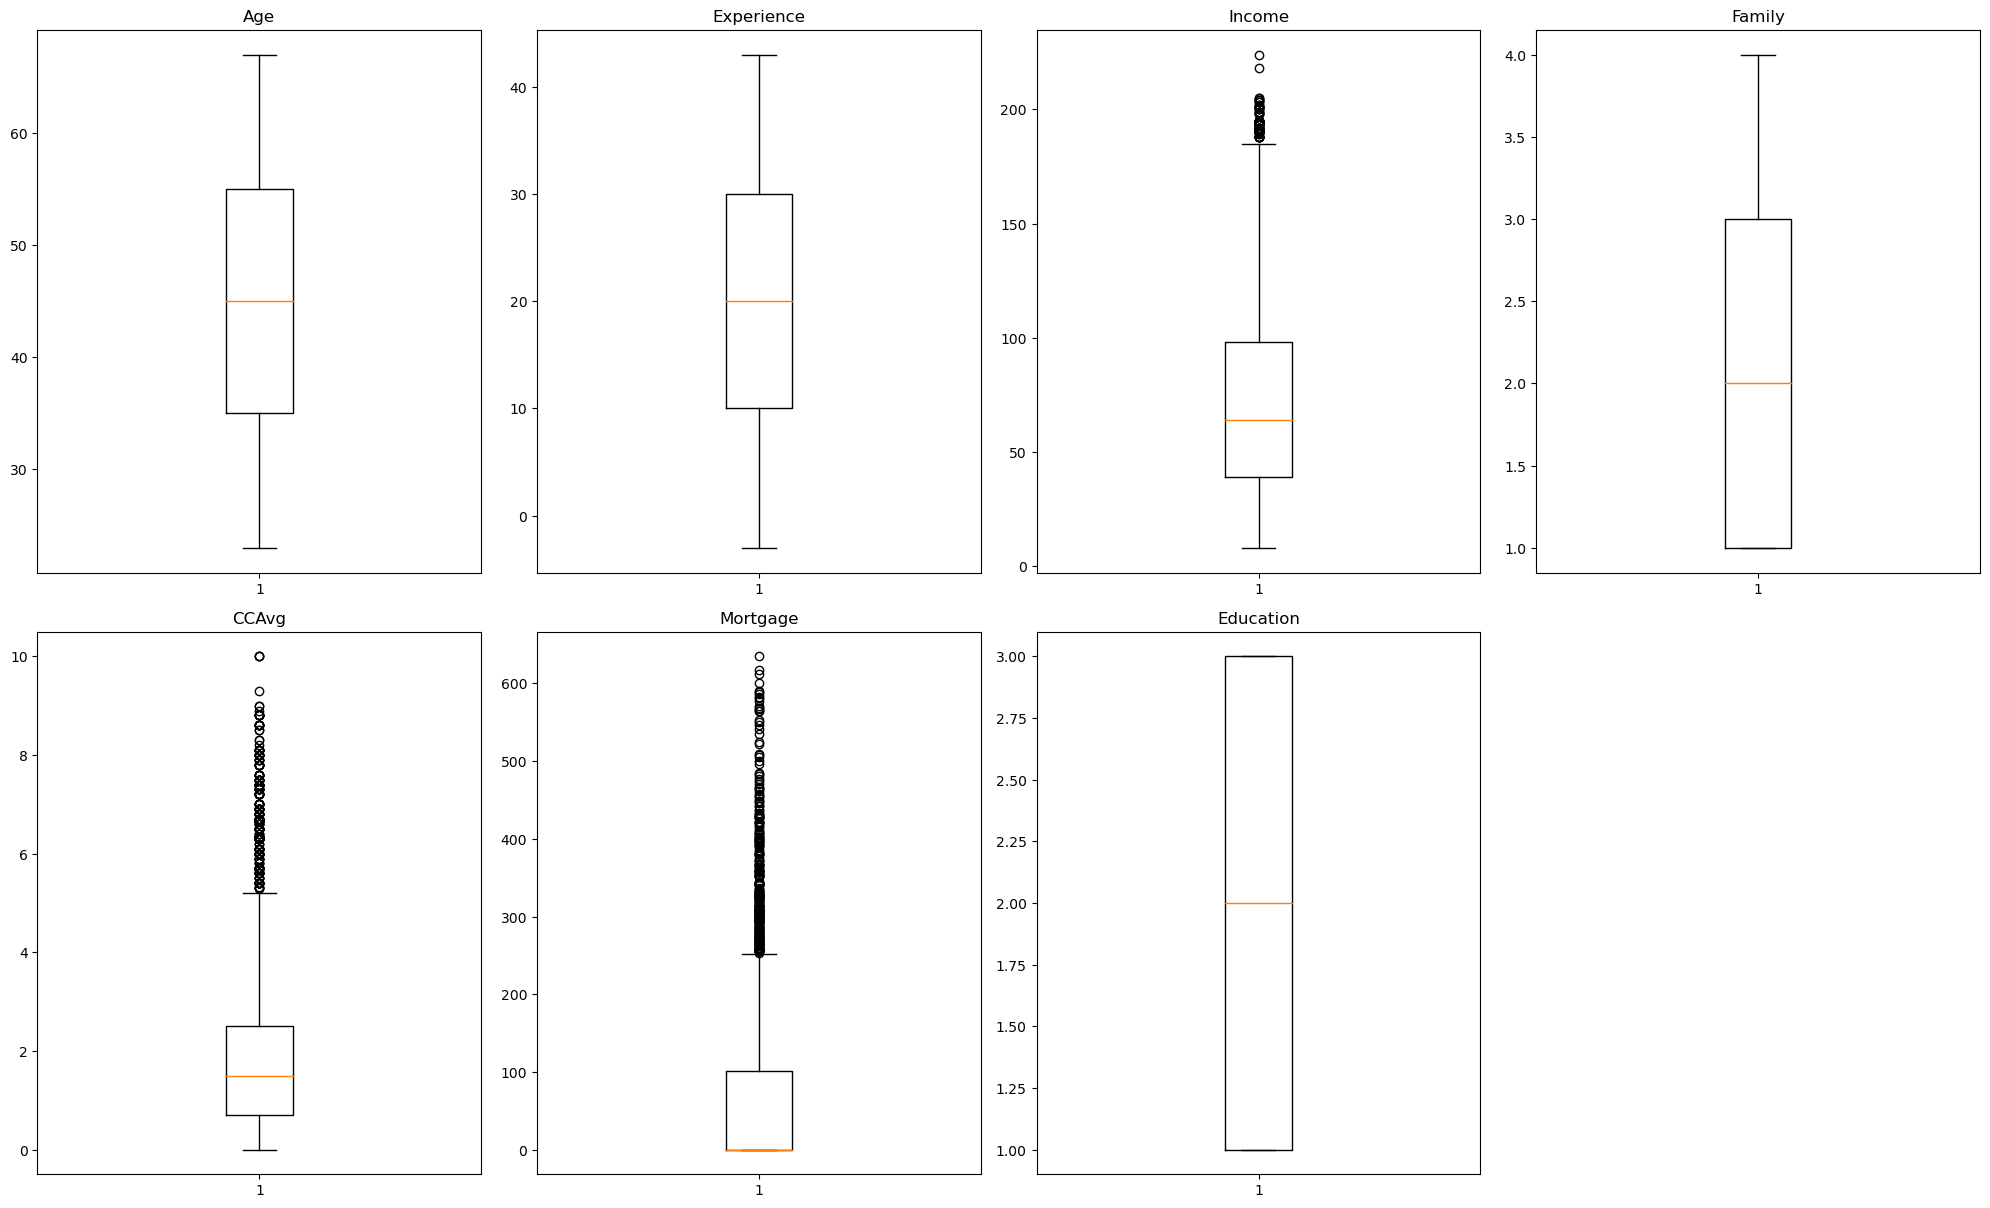

In [27]:
# numerical_col = df.select_dtypes(include=np.number).columns.tolist()
numerical_col = [
    "Age",
    "Experience",
    "Income",
    "Family",
    "CCAvg",
    "Mortgage",
    "Education",
]
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Observations

- No outlier treatment will be performed for the three variables which have outliers: income, CCAvg, and mortgage.  
- All of these variables would be expected to have outlying data. This is valuable data for modeling and will be retained. 
- The ID and ZIPcode variables will be deleted at later stages of this analysis and are thus not included in these vertical
  boxplots.

In [28]:
# Determine the unique value counts
# Make list of columns for unique value counts
cols_cat = [
    "ZIPCode",
    "Personal_Loan",
    "Education",
    "Securities_Account",
    "CD_Account",
    "Online",
    "CreditCard",
]

# Print unique categorical level counts for each column
for column in cols_cat:
    print(df[column].value_counts())
    print("-" * 20)

94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
96145      1
94087      1
91024      1
93077      1
94598      1
Name: ZIPCode, Length: 467, dtype: int64
--------------------
0    4520
1     480
Name: Personal_Loan, dtype: int64
--------------------
1    2096
3    1501
2    1403
Name: Education, dtype: int64
--------------------
0    4478
1     522
Name: Securities_Account, dtype: int64
--------------------
0    4698
1     302
Name: CD_Account, dtype: int64
--------------------
1    2984
0    2016
Name: Online, dtype: int64
--------------------
0    3530
1    1470
Name: CreditCard, dtype: int64
--------------------


In [29]:
# Investigate experience negative values
neg_exp = df.loc[(df["Experience"] < 0)]
neg_exp

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,90,25,-1,113,94303,4,2.30,3,0,0,0,0,0,1
226,227,24,-1,39,94085,2,1.70,2,0,0,0,0,0,0
315,316,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0
451,452,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
524,525,24,-1,75,93014,4,0.20,1,0,0,0,0,1,0
536,537,25,-1,43,92173,3,2.40,2,176,0,0,0,1,0
540,541,25,-1,109,94010,4,2.30,3,314,0,0,0,1,0
576,577,25,-1,48,92870,3,0.30,3,0,0,0,0,0,1
583,584,24,-1,38,95045,2,1.70,2,0,0,0,0,1,0
597,598,24,-2,125,92835,2,7.20,1,0,0,1,0,0,1


### Observations

- The negative values for experience are primarily for those 30 years of age or younger. The relationship between age and
  experience will be further explored in the bivariate analysis section.

### Multivariate Analysis 

<Axes: >

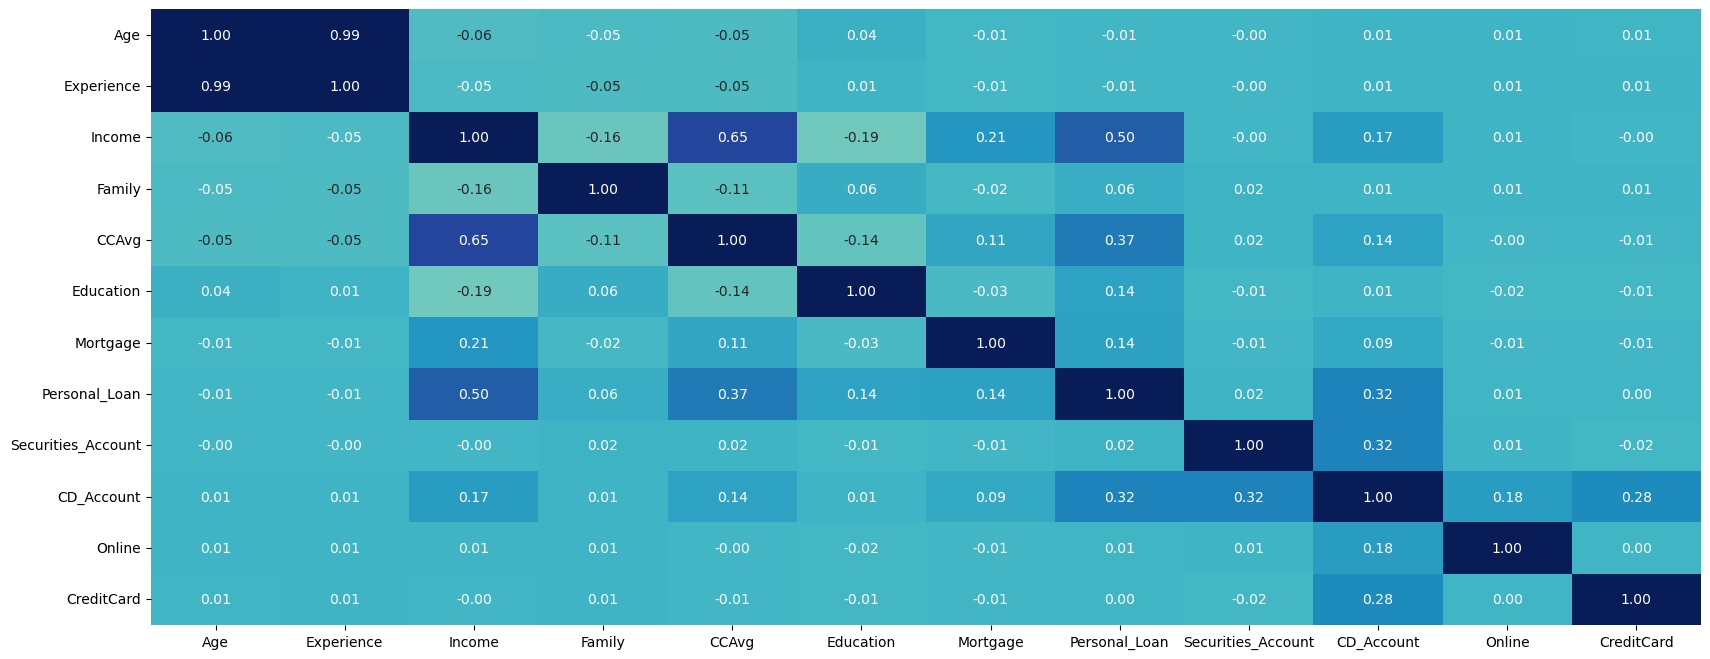

In [30]:
# Initial check for variable relationships and screen for colinearity
#Create a 12 x 12 correlation matrix and check for correlation
num_var = ['Age','Experience','Income','Family', 'CCAvg', 'Education', 
         'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']

corr = df[num_var].corr()

# plot the heatmap

plt.figure(figsize=(20, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="YlGnBu", cbar=False)


### Observations

- There is a strong 0.99 positive correlation between age and experience. 
- The variables most positively correlated with personal loan are income (0.50), CCAvg (0.37), and CD_Acct (0.32). 
- CCAvg is aso positively correlated with income (0.65).

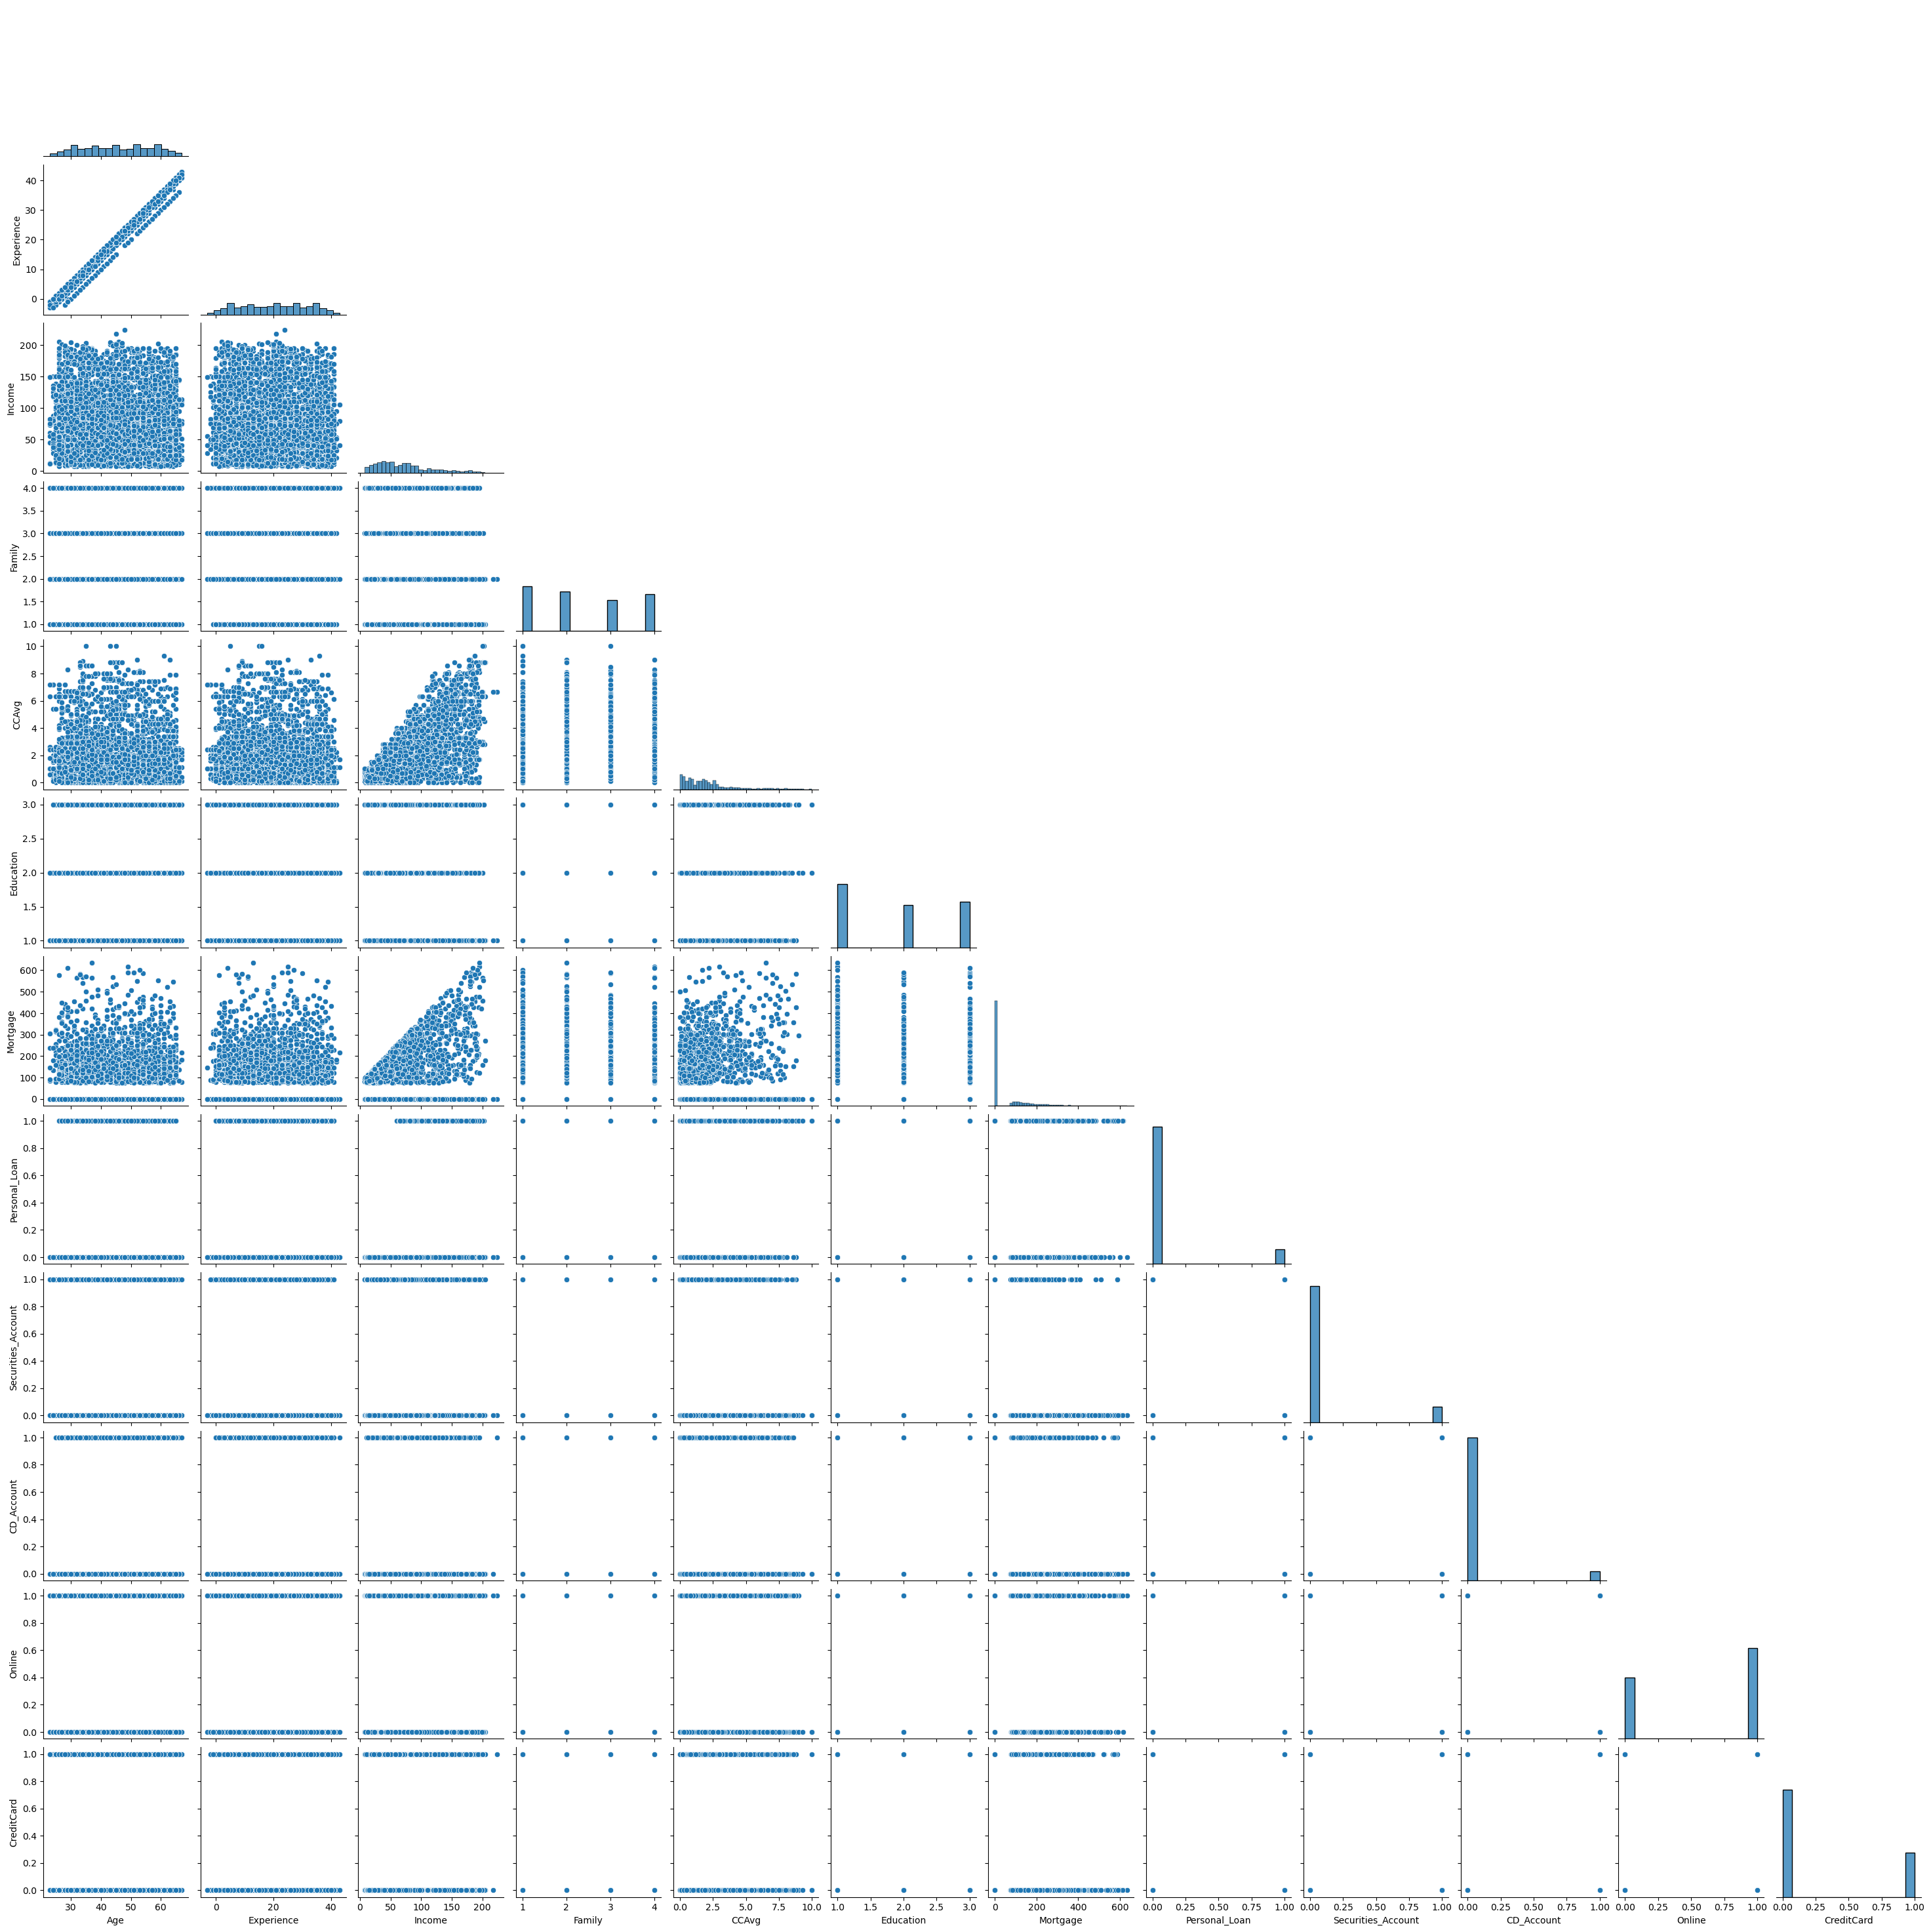

In [31]:
# Present pairplot of overall dataset numerical values
sns.pairplot(data=df[num_var], kind="scatter", corner=True)

### Observations

- The pairplot shows the very strong strong 0.99 positive correlation between age and experience. 
- Mortgage and CCAvg show a positively correlating trend with income. 

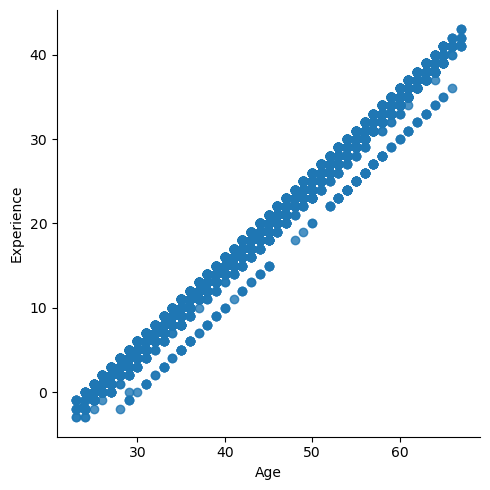

In [32]:
# Lmplot of experience as a function of age
# Investigate relationship between age and experience
sns.lmplot(data=df, x="Age", y="Experience")

## Data Preprocessing

### The experience category is dropped as it is adding no useful information as it is highly colinear with age.

In [33]:
# Drop Experience
df.drop(["Experience"], axis=1, inplace=True)

In [34]:
# Definition to prepare to convert zip codes to county (string) data
sr = SearchEngine()

In [35]:
# Initialize 2 new dataframe colums
df["Zip"] = np.nan
df["Local"] = np.nan

In [36]:
# Retrieve data for converting zipcode to county
for i in range(0, 5000):
    zc = df["ZIPCode"][i]
    z = sr.by_zipcode(zc)
    if z is None:
        val = "No Value"
        df["Zip"][i] = zc
        df["Local"][i] = val
    else:
        df["Zip"][i] = z.zipcode
        df["Local"][i] = z.county
        


In [37]:
#Display first 5 rows
df.head()


,ID,Age,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Zip,Local
0,1,25,49,91107,4,1.6,1,0,0,1,0,0,0,91107,Los Angeles County
1,2,45,34,90089,3,1.5,1,0,0,1,0,0,0,90089,Los Angeles County
2,3,39,11,94720,1,1.0,1,0,0,0,0,0,0,94720,Alameda County
3,4,35,100,94112,1,2.7,2,0,0,0,0,0,0,94112,San Francisco County
4,5,35,45,91330,4,1.0,2,0,0,0,0,0,1,91330,Los Angeles County


In [38]:
#Display last 5 rows
df.tail()

,ID,Age,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Zip,Local
4995,4996,29,40,92697,1,1.9,3,0,0,0,0,1,0,92697,Orange County
4996,4997,30,15,92037,4,0.4,1,85,0,0,0,1,0,92037,San Diego County
4997,4998,63,24,93023,2,0.3,3,0,0,0,0,0,0,93023,Ventura County
4998,4999,65,49,90034,3,0.5,2,0,0,0,0,1,0,90034,Los Angeles County
4999,5000,28,83,92612,3,0.8,1,0,0,0,0,1,1,92612,Orange County


In [39]:
#Display 10 random rows
df.sample(10)

,ID,Age,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Zip,Local
473,474,64,182,93955,1,1.2,2,547,1,0,0,1,0,93955,Monterey County
2932,2933,41,154,92407,1,7.0,1,0,0,0,0,0,1,92407,San Bernardino County
3982,3983,24,119,94566,1,1.5,1,0,0,0,0,1,0,94566,Alameda County
881,882,44,154,92116,2,8.8,1,0,0,0,0,1,0,92116,San Diego County
3158,3159,54,64,90095,2,0.8,3,0,0,1,0,1,0,90095,Los Angeles County
4714,4715,27,81,90291,3,1.5,1,307,0,1,1,1,1,90291,Los Angeles County
4920,4921,42,28,94002,4,1.5,3,91,0,0,0,1,1,94002,San Mateo County
2878,2879,45,122,94590,4,4.1,2,0,1,0,0,1,0,94590,Solano County
278,279,50,21,91125,4,1.0,1,0,0,0,0,1,0,91125,Los Angeles County
986,987,53,101,90245,4,4.9,1,0,0,0,0,1,0,90245,Los Angeles County


In [40]:
# Check dataframe after addings columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
 13  Zip                 5000 non-null   object 
 14  Local               5000 non-null   object 
dtypes: float64(1), int64(12), object(2)
memory usage: 586.1

In [41]:
# Check for null values
df.isnull().sum().sort_values(ascending=False)

ID                    0
Age                   0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
Zip                   0
Local                 0
dtype: int64

In [42]:
# Check county value counts
print(df["Local"].value_counts())

Los Angeles County        1095
San Diego County           568
Santa Clara County         563
Alameda County             500
Orange County              339
San Francisco County       257
San Mateo County           204
Sacramento County          184
Santa Barbara County       154
Yolo County                130
Monterey County            128
Ventura County             114
San Bernardino County      101
Contra Costa County         85
Santa Cruz County           68
Riverside County            56
Marin County                54
Kern County                 54
No Value                    34
Solano County               33
San Luis Obispo County      33
Humboldt County             32
Sonoma County               28
Fresno County               26
Placer County               24
Butte County                19
Shasta County               18
El Dorado County            17
Stanislaus County           15
San Benito County           14
San Joaquin County          13
Mendocino County             8
Siskiyou

In [43]:
# Drop the 34 rows with "no value" for county
df.drop(df.index[df["Local"] == "No Value"], inplace=True)

In [44]:
# Standardize local to string type
df["Local"] = df["Local"].astype(str)

In [45]:
# Strip blanks out of local object
df["Local"] = df["Local"].str.strip()

### Standardize and shorten county names

In [46]:
df["Local"] = df["Local"].replace(
    {
        "Los Angeles County": "Angeles",
        "San Diego County": "Diego",
        "Santa Clara County": "Clara",
        "Alameda County": "Alameda",
        "Orange County": "Orange",
        "San Francisco County": "Francisco",
        "San Mateo County": "Mateo",
        "Sacramento County": "Sacramento",
        "Santa Barbara County": "Barbara",
        "Yolo County": "Yolo",
        "Monterey County": "Monterey",
        "Ventura County": "Ventura",
        "San Bernardino County": "Bernardino",
        "Contra Costa County": "Contra",
        "Santa Cruz County": "Cruz",
        "Riverside County": "Riverside",
        "Marin County": "Marin",
        "Kern County": "Kern",
        "San Luis Obispo County": "Obispo",
        "Solano County": "Solano",
        "Humboldt County": "Humboldt",
        "Sonoma County": "Sonoma",
        "Fresno County": "Fresno",
        "Placer County": "Placer",
        "Butte County": "Butte",
        "Shasta County": "Shasta",
        "El Dorado County": "Dorado",
        "Stanislaus County": "Stanislaus",
        "San Benito County": "Benito",
        "San Joaquin County": "Joaquin",
        "Mendocino County": "Mendocino",
        "Siskiyou County": "Siskiyou",
        "Tuolumne County": "Tuolumne",
        "Merced County": "Merced",
        "Trinity County": "Trinity",
        "Lake County": "Lake",
        "Imperial County": "Imperial",
        "Napa County": "Napa",
    }
)

In [47]:
#Confirm only 34 rows deleted
print(df["Local"].value_counts().sum())

4966


In [48]:
# Drop ID column as this has no relationship to taking a loan
df.drop(["ID"], axis=1, inplace=True)

In [49]:
# Drop zipcode column as it has been converted to county data 
df.drop(["ZIPCode"], axis=1, inplace=True)

In [50]:
# Drop zip temporary data column
df.drop(["Zip"], axis=1, inplace=True)

In [51]:
# Make a copy of dataframe to be used for decision tree analysis
df2 = df.copy()

In [52]:
# Make additional copy of dataframe to be used for later investigation of any misclassified points
df3 = df.copy()

In [53]:
df3.head()

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Local
0,25,49,4,1.6,1,0,0,1,0,0,0,Angeles
1,45,34,3,1.5,1,0,0,1,0,0,0,Angeles
2,39,11,1,1.0,1,0,0,0,0,0,0,Alameda
3,35,100,1,2.7,2,0,0,0,0,0,0,Francisco
4,35,45,4,1.0,2,0,0,0,0,0,1,Angeles


In [54]:
df3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4966 non-null   int64  
 1   Income              4966 non-null   int64  
 2   Family              4966 non-null   int64  
 3   CCAvg               4966 non-null   float64
 4   Education           4966 non-null   int64  
 5   Mortgage            4966 non-null   int64  
 6   Personal_Loan       4966 non-null   int64  
 7   Securities_Account  4966 non-null   int64  
 8   CD_Account          4966 non-null   int64  
 9   Online              4966 non-null   int64  
 10  CreditCard          4966 non-null   int64  
 11  Local               4966 non-null   object 
dtypes: float64(1), int64(10), object(1)
memory usage: 504.4+ KB


### Model Evaluation Criterion

- Model can make wrong predictions as:
- Predicting a customer will take the personal loan but in reality the customer will not take the personal loan - Loss of
  resources
- Predicting a customer will not take the personal loan but in reality the customer was going to take the personal loan - Loss
  of opportunity
  
- Which parameter is most important?

- Losing a potential customer by predicting that the customer will not be taking the personal loan but in reality the customer
  was going to take the personal loan.
- How to reduce this loss i.e need to reduce False Negatives?
- Bank would want Recall to be maximized, greater the Recall higher the chances of minimizing false negatives. Hence, the focus
  should be on increasing Recall or minimizing the false negatives.

### Build the logistic regression model

In [55]:
# Define a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


In [56]:
# Define a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [57]:
# Drop target variable and get dummy variables local column
X = df.drop("Personal_Loan", axis=1)
Y = df["Personal_Loan"]

# creating dummy variables
X = pd.get_dummies(X)

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [58]:
#Print information for training and test data
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3476, 48)
Shape of test set :  (1490, 48)
Percentage of classes in training set:
0    0.905351
1    0.094649
Name: Personal_Loan, dtype: float64
Percentage of classes in test set:
0    0.900671
1    0.099329
Name: Personal_Loan, dtype: float64


### Observations

- This is a relatively imbalanced data set with a low percentage of 1's in the dependent variable. 
- This is not desirable for logistic regression from a standpoint of an accurate estimation of the model intercept and
  predicted probabilities.

In [59]:
# Develop logistic regression model
# Investigated setting the class_weights parameter to "balanced" however this resulted in an F1 score decrease

model = LogisticRegression(solver="newton-cg", random_state=1)
lg = model.fit(X_train, y_train)

### Observations

The logistic regression model was executed first with the default class_weights parameter "balanced" prior to executing the model with class weights set to default "none". This resulted in the following differences in test set performance with the default threshold:

class_weights = "none"
test accuracy: 0.949
test recall:   0.628
test precision: 0.816
test f1: 0.709

class_weights = "balanced"
test accuracy:  0.888
test recall: 0.872
test precision: 0.466
test f1: 0.607

Proceeded with the class_weights setting as "none" due to better F1 score performance.

In [60]:
# Calculate log odds 
log_odds = lg.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=["coef"]).T

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Local_Alameda,Local_Angeles,Local_Barbara,Local_Benito,Local_Bernardino,Local_Butte,Local_Clara,Local_Contra,Local_Cruz,Local_Diego,Local_Dorado,Local_Francisco,Local_Fresno,Local_Humboldt,Local_Imperial,Local_Joaquin,Local_Kern,Local_Lake,Local_Marin,Local_Mateo,Local_Mendocino,Local_Merced,Local_Monterey,Local_Napa,Local_Obispo,Local_Orange,Local_Placer,Local_Riverside,Local_Sacramento,Local_Shasta,Local_Siskiyou,Local_Solano,Local_Sonoma,Local_Stanislaus,Local_Trinity,Local_Tuolumne,Local_Ventura,Local_Yolo
coef,0.009242,0.054836,0.726463,0.121403,1.536055,0.00058,-0.857052,3.650238,-0.627968,-0.990598,-0.020511,0.063385,-0.210252,-0.218914,-0.394004,0.338106,0.697724,1.183805,-0.380035,0.035226,0.15759,0.262525,-0.30933,-0.329727,-0.000633,-0.395728,0.198398,-0.00586,0.622657,-1.198378,-0.035944,-0.453185,0.012674,0.0,-0.474794,-0.086757,0.259536,-0.113487,-0.005824,-0.128526,-0.013579,0.448129,0.645145,-0.175707,-0.084888,-0.149193,0.123109,0.136752


### Observations

- An increase in positive coefficients leads to an increase in probablity of taking a loan. More negative coefficient decreases
  chance. Coefficients of logistic regression in terms of log(odds) to finds odds exponentiate the coefficients odds = exp(b) %
  change in odds given as odds = (exp(b) -1) * 100

In [61]:
# converting coefficients to odds
odds = np.exp(lg.coef_[0])

# finding the percentage change
perc_change_odds = (np.exp(lg.coef_[0]) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train.columns).T

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Local_Alameda,Local_Angeles,Local_Barbara,Local_Benito,Local_Bernardino,Local_Butte,Local_Clara,Local_Contra,Local_Cruz,Local_Diego,Local_Dorado,Local_Francisco,Local_Fresno,Local_Humboldt,Local_Imperial,Local_Joaquin,Local_Kern,Local_Lake,Local_Marin,Local_Mateo,Local_Mendocino,Local_Merced,Local_Monterey,Local_Napa,Local_Obispo,Local_Orange,Local_Placer,Local_Riverside,Local_Sacramento,Local_Shasta,Local_Siskiyou,Local_Solano,Local_Sonoma,Local_Stanislaus,Local_Trinity,Local_Tuolumne,Local_Ventura,Local_Yolo
Odds,1.009285,1.056368,2.067753,1.129080,4.646224,1.000580,0.424411,38.483814,0.533675,0.371354,0.979698,1.065437,0.810380,0.803391,0.674351,1.402290,2.009175,3.266779,0.683838,1.035854,1.170686,1.300209,0.733939,0.71912,0.999367,0.673190,1.219448,0.994157,1.863873,0.301683,0.964694,0.635600,1.012754,1.0,0.622013,0.916900,1.296329,0.892716,0.994193,0.879391,0.986513,1.565381,1.906263,0.838864,0.918615,0.861403,1.131008,1.146544
Change_odd%,0.928464,5.636760,106.775347,12.908037,364.622413,0.058001,-57.558877,3748.381369,-46.632474,-62.864559,-2.030206,6.543662,-18.962018,-19.660946,-32.564864,40.228959,100.917512,226.677940,-31.616230,3.585398,17.068601,30.020895,-26.606139,-28.08799,-0.063289,-32.680993,21.944767,-0.584318,86.387290,-69.831681,-3.530607,-36.439962,1.275429,0.0,-37.798689,-8.310016,29.632864,-10.728391,-0.580717,-12.060926,-1.348741,56.538050,90.626295,-16.113599,-8.138493,-13.859728,13.100765,14.654426


### Observations

- Taking a loan is strongly correlated with having a CD_Account and increased education

### Check model performance on training set (with default threshold)

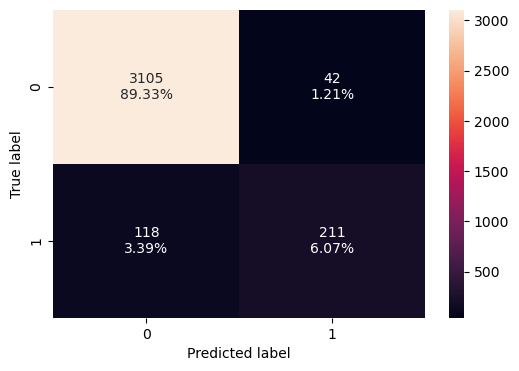

In [62]:
# creating confusion matrix for training set
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)

In [63]:
#Determine training performance
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.95397,0.641337,0.833992,0.725086


In [64]:
#Determine model coefficients and intercept
coef_df = pd.DataFrame(model.coef_)
coef_df["intercept"] = model.intercept_
print(coef_df)

          0         1         2         3         4        5         6  \
0  0.009242  0.054836  0.726463  0.121403  1.536055  0.00058 -0.857052   

          7         8         9        10        11        12        13  \
0  3.650238 -0.627968 -0.990598 -0.020511  0.063385 -0.210252 -0.218914   

         14        15        16        17        18        19       20  \
0 -0.394004  0.338106  0.697724  1.183805 -0.380035  0.035226  0.15759   

         21       22        23        24        25        26       27  \
0  0.262525 -0.30933 -0.329727 -0.000633 -0.395728  0.198398 -0.00586   

         28        29        30        31        32   33        34        35  \
0  0.622657 -1.198378 -0.035944 -0.453185  0.012674  0.0 -0.474794 -0.086757   

         36        37        38        39        40        41        42  \
0  0.259536 -0.113487 -0.005824 -0.128526 -0.013579  0.448129  0.645145   

         43        44        45        46        47  intercept  
0 -0.175707 -0.084888 -0.14

### Observations


- An increase in positive coefficients leads to an increase in probability of taking loan and negative decreases chance.

In [65]:
# Determine model score for training set
model_score = model.score(X_train, y_train)
print(model_score)

0.953970080552359


### Check model performance on test set (with default threshold)

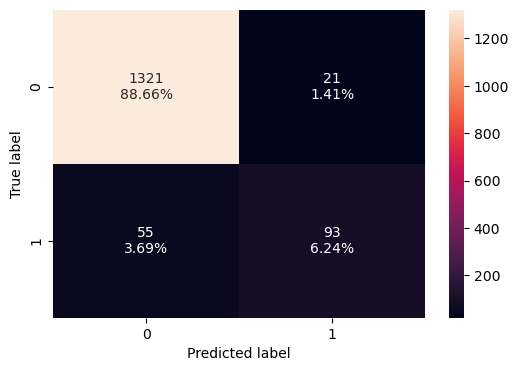

In [66]:
# creating confusion matrix for test set
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test)

In [67]:
#Determine model performance for test set
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test
)

print("Test set performance:")
log_reg_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.948993,0.628378,0.815789,0.709924


### Observations

- It is recommended that the F1 score is the correct metric to key on for this analysis.  The F1 incorporates both precision
  and recall into an overall score. 
- Keying only on recall can result in large numbers of false positives which will utilize company resources will little
  benefit.  
- Tables at the bottom of the logistic regression section compare these model results using the default threshold to model
  results obtained by using optimal thresholds for ROC-AUC and recall- precision evaluations.

In [68]:
# Determine model score for test set
model_score = model.score(X_test, y_test)
print(model_score)

0.9489932885906041


### Observations

- Determine optimal threshold per AUC-ROC curve and determine if model performance can be improved

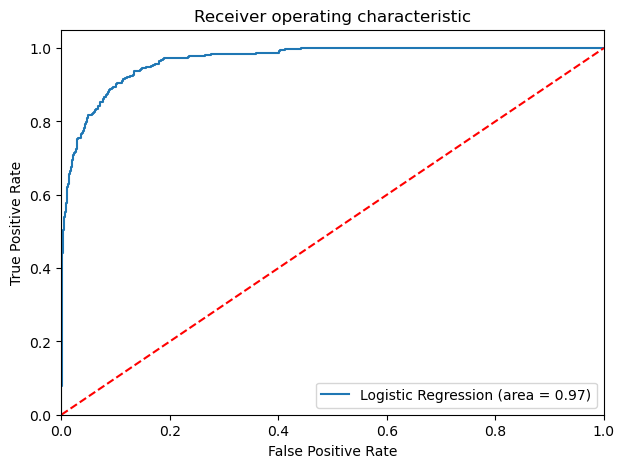

In [69]:
# Using training data
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

###  Observations

- Area under curve for training set is 0.97 which indicates high model performance

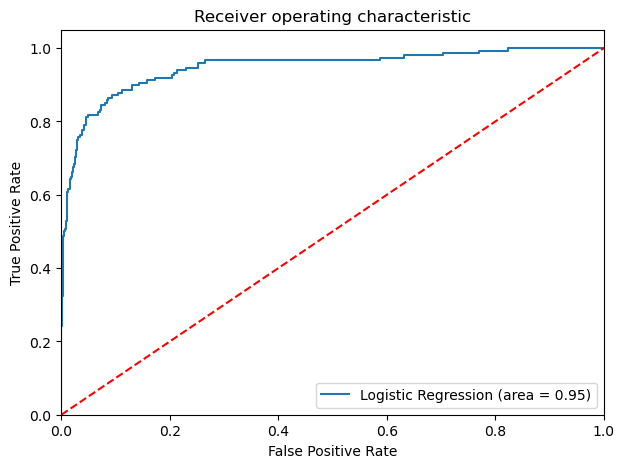

In [70]:
# Find the roc auc score for test data
logit_roc_auc_test = roc_auc_score(
    y_test, lg.predict_proba(X_test)[:, 1]
)  # The indexing represents predicted probabilities for class 1
# Find fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(7, 5))
# Plot roc curve
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### Observations

- Area under curve for testing set is 0.95 which indicates high model performance


### Calculate optimal threshold using ROC-AUC curve (value that best seperated the true positive rate and false  positive rate)

In [71]:
# Optimal threshold as per AUC-ROC curve - this uses training data
# The optimal cut off would be where tpr is high and fpr is low
# roc_curve returns the fpr, tpr and threshold values which takes the original data and predicted probabilities for the class 1.
fpr, tpr, thresholds = roc_curve(
    y_train, lg.predict_proba(X_train)[:, 1]
)  # The indexing represents predicted probabilities for class 1

optimal_idx = np.argmax(
    tpr - fpr
)  # Finds the index that contains the max difference between tpr and fpr
optimal_threshold_auc_roc = thresholds[
    optimal_idx
]  # stores the optimal threshold value
print(optimal_threshold_auc_roc)

0.09692958658046393


### Check model performance for training data with optimal threshold

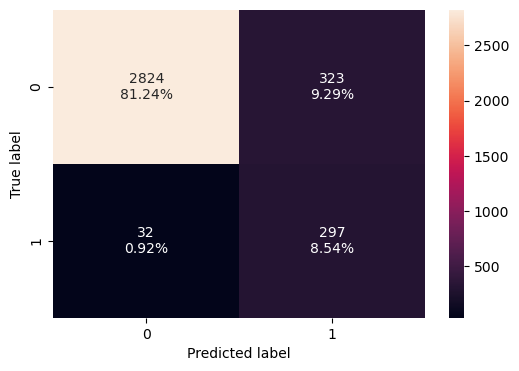

In [72]:
# creating confusion matrix for training data using optimal threshold
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)

In [73]:
# checking model performance for training data using optimal threshold
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.897871,0.902736,0.479032,0.625922


### Observations

- The F1 score for training data using the ROC-AUC threshold is below the training set F1 score using the default threshold

### Check model performance for test data with optimal threshold from AUC-ROC

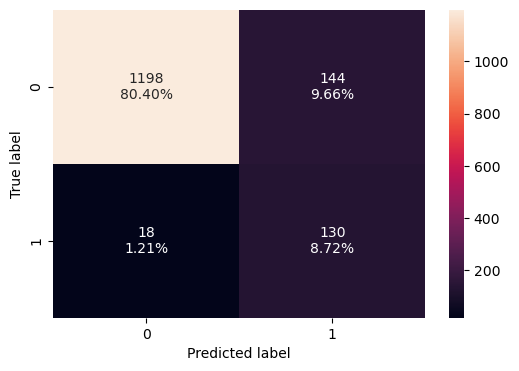

In [74]:
# creating confusion matrix for test set with optimal threshold
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

In [75]:
# checking model performance for test set with roc-auc optimal threshold
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)
print("Test set performance:")
log_reg_model_test_perf_threshold_auc_roc

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.891275,0.878378,0.474453,0.616114


### Observations

- The F1 score for the test set using the ROC-AUC threshold is less than the F1 score for the test set using the default
  threshold.

- Tables presenting a comparison of all logistic regression results are included below. Test set F1 score with default
  threshold is 0.71 as compared to a test set F1 score of 0.62 using the ROC-AUC optimal threshold.


### Determine If A Better Threshold Can Be Calculated Using Precision Recall 

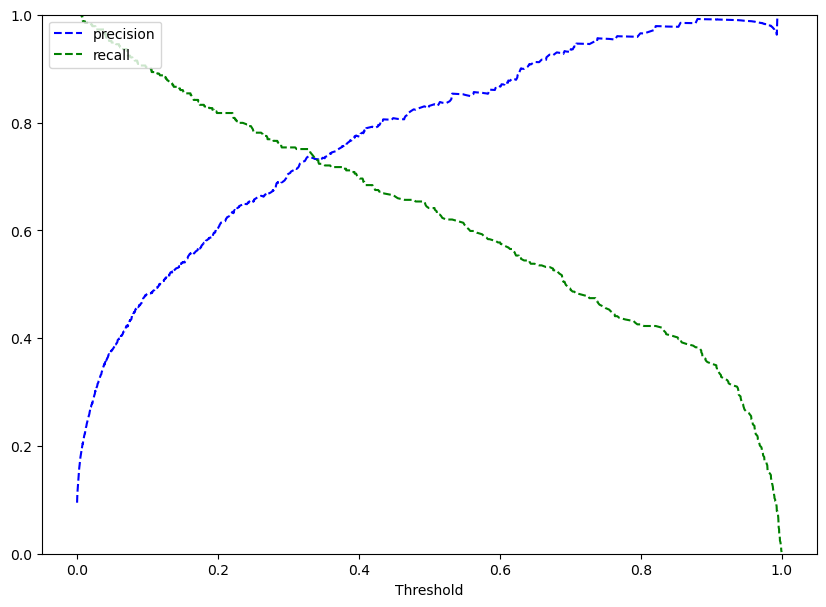

In [76]:
y_scores = lg.predict_proba(X_train)[:, 1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [77]:
# Determine Optimum Threshold Using Precision Recall Curve
for i in range(0, len(rec)):
    if prec[i] == rec[i]:
        print(i, tre[i])

3147 0.33685712614270064


In [78]:
# Setting the threshold
optimal_threshold_curve = 0.337

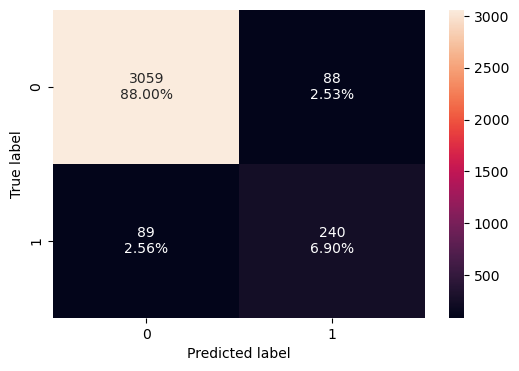

In [79]:
# Creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)

In [80]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.949079,0.729483,0.731707,0.730594


### Observations

- The training set F1 score using the optimum precision recall threshold is greater than the training F1 score using the
  default threshold.

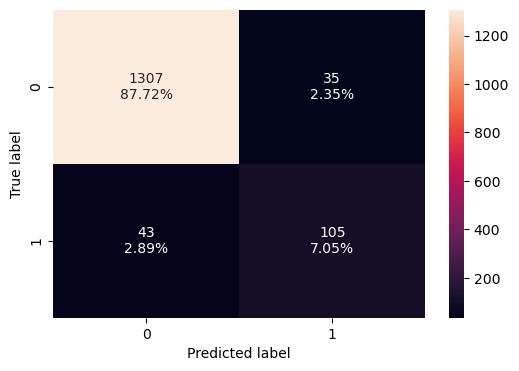

In [81]:
# creating confusion matrix 
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

In [82]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test set performance:")
log_reg_model_test_perf_threshold_curve

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.947651,0.709459,0.75,0.729167


### Observations

- The test set model F1 score using the precision recall optimal threshold is greater than the test set model F1 score using
  the default threshold.

### Logistic Regression Model Training Performance Summary

In [83]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.097 Threshold",
    "Logistic Regression-0.337 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.097 Threshold,Logistic Regression-0.337 Threshold
Accuracy,0.953970,0.897871,0.949079
Recall,0.641337,0.902736,0.729483
Precision,0.833992,0.479032,0.731707
F1,0.725086,0.625922,0.730594


### Observations

- Use of the precision recall optimal threshold of 0.337 provides the best performance for the F1 score which is a good
  criteria for evaluating an imbalanced data set. It is marginally superior to using the default threshold due to a greater
  recall value.  

- As shown above, keying only on recall can result in a model with low precision resulting in an excess number of false
  positives.

### Logistic Regression Model Testing Performance Summary

In [84]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.097 Threshold",
    "Logistic Regression-0.337 Threshold",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.097 Threshold,Logistic Regression-0.337 Threshold
Accuracy,0.948993,0.891275,0.947651
Recall,0.628378,0.878378,0.709459
Precision,0.815789,0.474453,0.750000
F1,0.709924,0.616114,0.729167


### Observations

- Use of the precision recall optimal threshold of 0.337 provides the best logistic regression performance for the F1 score
  which is a good criteria for evaluating an imbalanced data set. It is marginally superior to using the default threshold due
  to a greater recall value.  

- As shown above, keying only on recall can result in a model with low precision resulting in as excess number of false
  positives.

### Decision Tree Analysis

### Tables comparing all decision tree training and testing results are included at the bottom of this section.

In [85]:
X = df2.drop("Personal_Loan", axis=1)
Y = df2["Personal_Loan"]

# creating dummy variables
X = pd.get_dummies(X)  # drop_first=True

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(3476, 48) (1490, 48)


In [86]:
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
0    0.905351
1    0.094649
Name: Personal_Loan, dtype: float64
Percentage of classes in test set:
0    0.900671
1    0.099329
Name: Personal_Loan, dtype: float64


In [87]:
y_train.value_counts()

0    3147
1     329
Name: Personal_Loan, dtype: int64

### Decision tree classifier with no pre-pruning and class_weighting = "balanced" due to imbalanced data set

In [88]:
dTree = DecisionTreeClassifier(
    criterion="gini", class_weight="balanced", random_state=1
)

In [89]:
dTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [90]:
## Function to create confusion matrix
def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth  
    
    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [91]:
##  Function to calculate recall score
def get_recall_score(model):
    """
    model : classifier to predict values of X

    """
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
    print("Recall on test set : ", metrics.recall_score(y_test, pred_test))

In [92]:
##  Function to calculate precision score
def get_precision_score(model):
    """
    model : classifier to predict values of X

    """
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Precision on training set : ", metrics.precision_score(y_train, pred_train))
    print("Precision on test set : ", metrics.precision_score(y_test, pred_test))

In [93]:
##  Function to calculate F1 score
def get_f1_score(model):
    """
    model : classifier to predict values of X

    """
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("F1 score on training set : ", metrics.f1_score(y_train, pred_train))
    print("F1 score on test set : ", metrics.f1_score(y_test, pred_test))

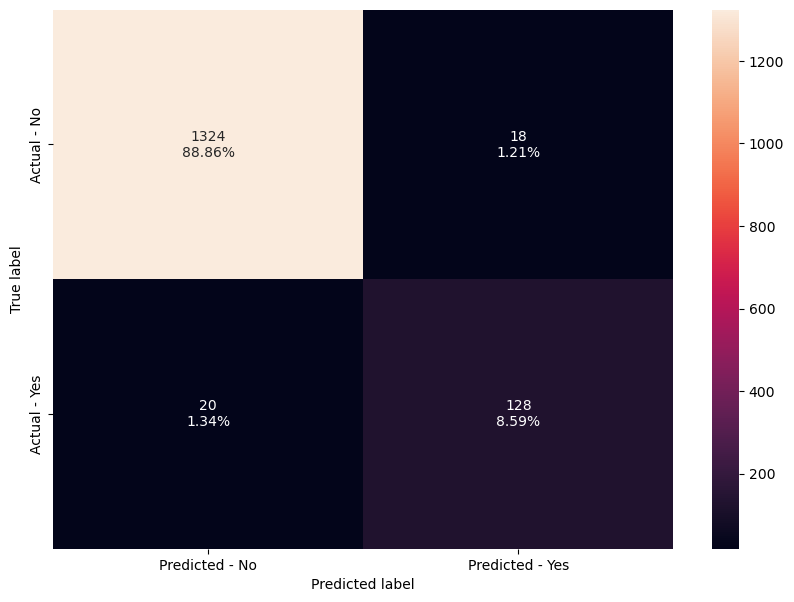

In [94]:
# Confusion matrix
make_confusion_matrix(dTree, y_test)

In [95]:
print("Accuracy on training set : ", dTree.score(X_train, y_train))
print("Accuracy on test set : ", dTree.score(X_test, y_test))

Accuracy on training set :  1.0
Accuracy on test set :  0.974496644295302


### Observations

- Model may be overtrained.  There were no limits on max depth and no pruning.

In [96]:
# Recall on train and test
get_recall_score(dTree)

Recall on training set :  1.0
Recall on test set :  0.8648648648648649


In [97]:
# Precision on train and test
get_precision_score(dTree)

Precision on training set :  1.0
Precision on test set :  0.8767123287671232


In [98]:
# F1 score on train and test
get_f1_score(dTree)

F1 score on training set :  1.0
F1 score on test set :  0.870748299319728


### Visualize the Decision Tree

In [99]:
feature_names = list(X.columns)
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'Local_Alameda', 'Local_Angeles', 'Local_Barbara', 'Local_Benito', 'Local_Bernardino', 'Local_Butte', 'Local_Clara', 'Local_Contra', 'Local_Cruz', 'Local_Diego', 'Local_Dorado', 'Local_Francisco', 'Local_Fresno', 'Local_Humboldt', 'Local_Imperial', 'Local_Joaquin', 'Local_Kern', 'Local_Lake', 'Local_Marin', 'Local_Mateo', 'Local_Mendocino', 'Local_Merced', 'Local_Monterey', 'Local_Napa', 'Local_Obispo', 'Local_Orange', 'Local_Placer', 'Local_Riverside', 'Local_Sacramento', 'Local_Shasta', 'Local_Siskiyou', 'Local_Solano', 'Local_Sonoma', 'Local_Stanislaus', 'Local_Trinity', 'Local_Tuolumne', 'Local_Ventura', 'Local_Yolo']


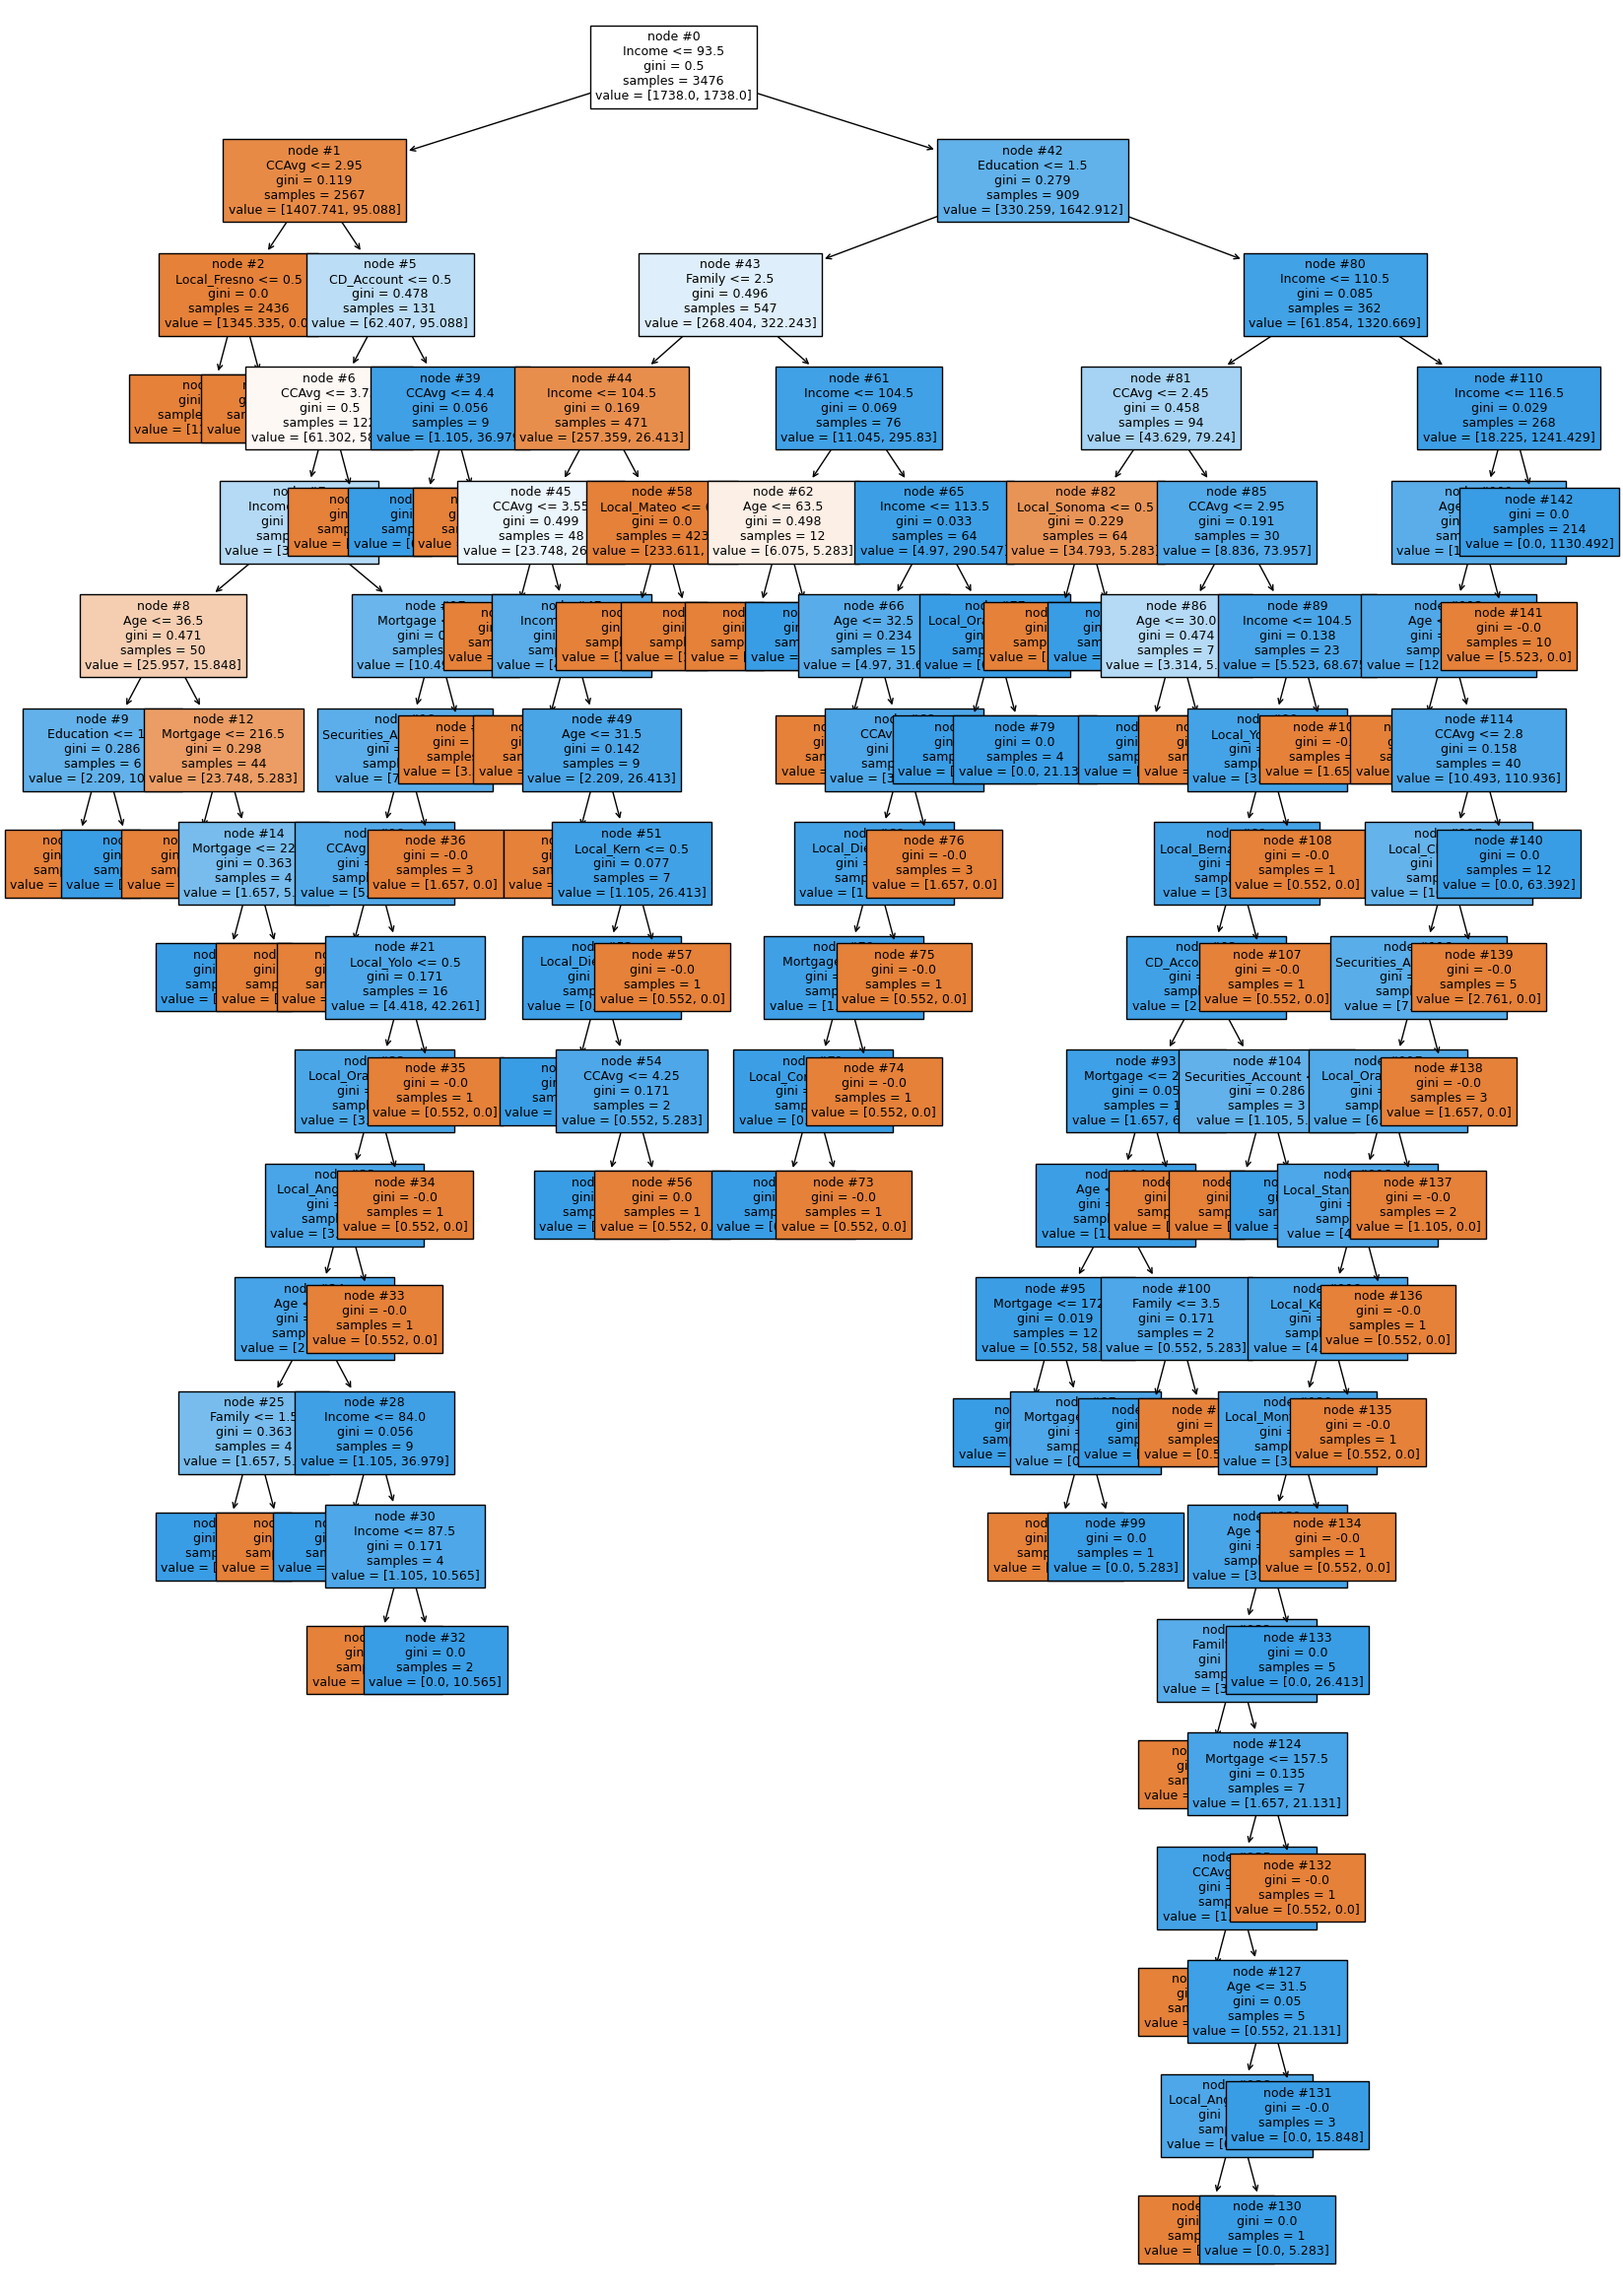

In [100]:
plt.figure(figsize=(20, 30))
tree.plot_tree(
    dTree,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=None,
)
plt.show()

### Observations

- This mode is overtrained and is not feasible to use.  The model will be rebuilt with a max depth limit.

In [101]:
# Text report showing the decision tree rules
print(tree.export_text(dTree, feature_names=feature_names, show_weights=True))

|--- Income <= 93.50
|   |--- CCAvg <= 2.95
|   |   |--- Local_Fresno <= 0.50
|   |   |   |--- weights: [1338.71, 0.00] class: 0
|   |   |--- Local_Fresno >  0.50
|   |   |   |--- weights: [6.63, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account <= 0.50
|   |   |   |--- CCAvg <= 3.75
|   |   |   |   |--- Income <= 81.50
|   |   |   |   |   |--- Age <= 36.50
|   |   |   |   |   |   |--- Education <= 1.50
|   |   |   |   |   |   |   |--- weights: [2.21, 0.00] class: 0
|   |   |   |   |   |   |--- Education >  1.50
|   |   |   |   |   |   |   |--- weights: [0.00, 10.57] class: 1
|   |   |   |   |   |--- Age >  36.50
|   |   |   |   |   |   |--- Mortgage <= 216.50
|   |   |   |   |   |   |   |--- weights: [22.09, 0.00] class: 0
|   |   |   |   |   |   |--- Mortgage >  216.50
|   |   |   |   |   |   |   |--- Mortgage <= 223.50
|   |   |   |   |   |   |   |   |--- weights: [0.00, 5.28] class: 1
|   |   |   |   |   |   |   |--- Mortgage >  223.50
|   |   |   |   |   |   |   |   |-

In [102]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        dTree.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                             Imp
Income              6.255959e-01
Family              1.322458e-01
CCAvg               1.027991e-01
Education           8.203312e-02
Age                 2.009653e-02
Mortgage            9.985862e-03
CD_Account          7.940975e-03
Local_Sonoma        5.277708e-03
Securities_Account  3.946700e-03
Local_Clara         2.238997e-03
Local_Orange        1.560297e-03
Local_Kern          1.135286e-03
Local_Angeles       1.128548e-03
Local_Yolo          1.101115e-03
Local_Diego         6.307540e-04
Local_Contra        6.246421e-04
Local_Bernardino    5.828372e-04
Local_Monterey      5.494420e-04
Local_Stanislaus    5.264519e-04
Local_Fresno        2.578173e-16
Local_Mateo         7.461461e-17
Local_Tuolumne      0.000000e+00
Local_Ventura       0.000000e+00
Local_Trinity       0.000000e+00
Local_Obispo        0.000000e+00
Local_Solano        0.000000e+00
Local_Siskiyou      0.000000e+00
Local_Shasta        0.000000e+00
Local_Sacramento    0.000000e+00
Local_Rive

### Observations

- County of residence of the cusomer has almost zero impact on whether or not a person takes a loan.

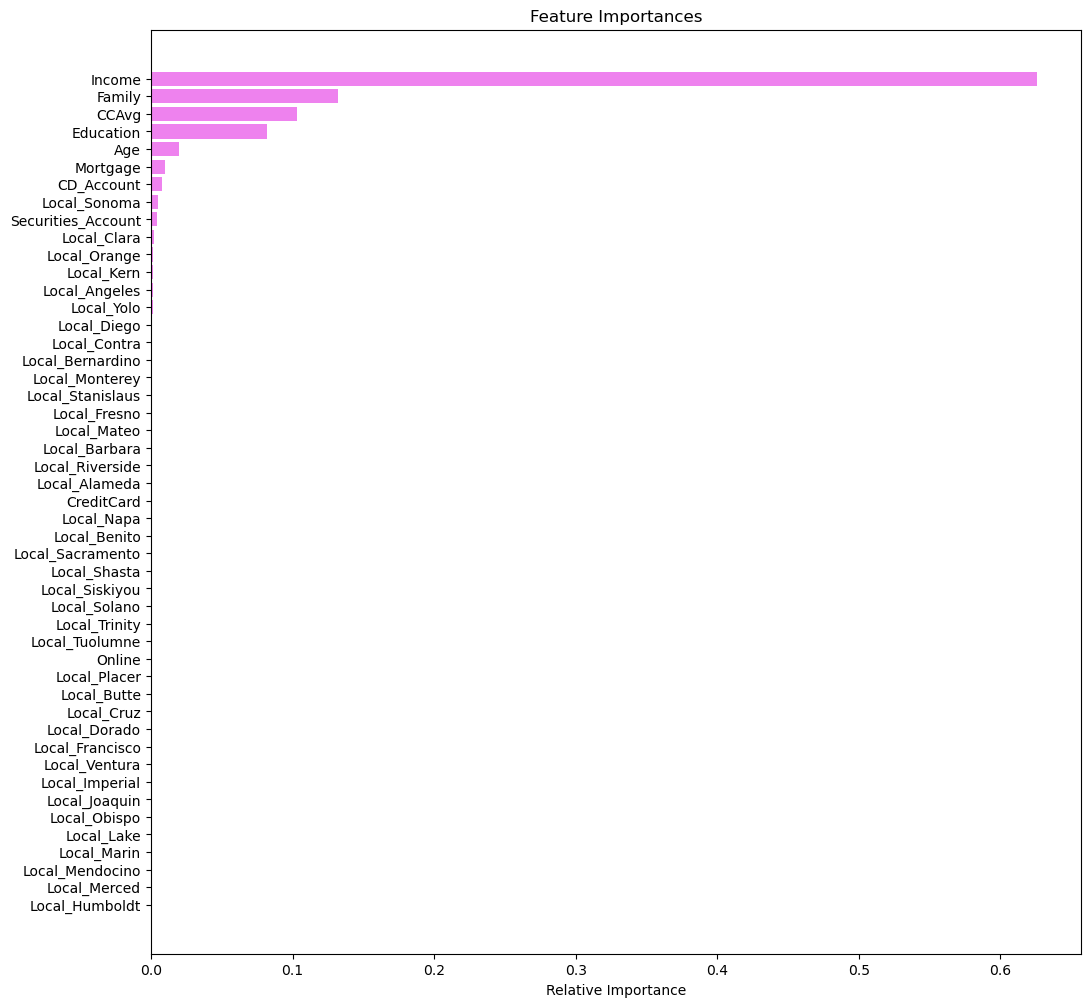

In [103]:
importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Observations

- This tree is overly complex and may provide better performance if pruning is implemented.

### Implement pre-pruning with maximum depth restricted to 3

In [104]:
#  Pre-Pruning
dTree1 = DecisionTreeClassifier(
    criterion="gini", class_weight="balanced", max_depth=3, random_state=1
)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=1)

### Confusion matrix with tree max depth restricted to 3

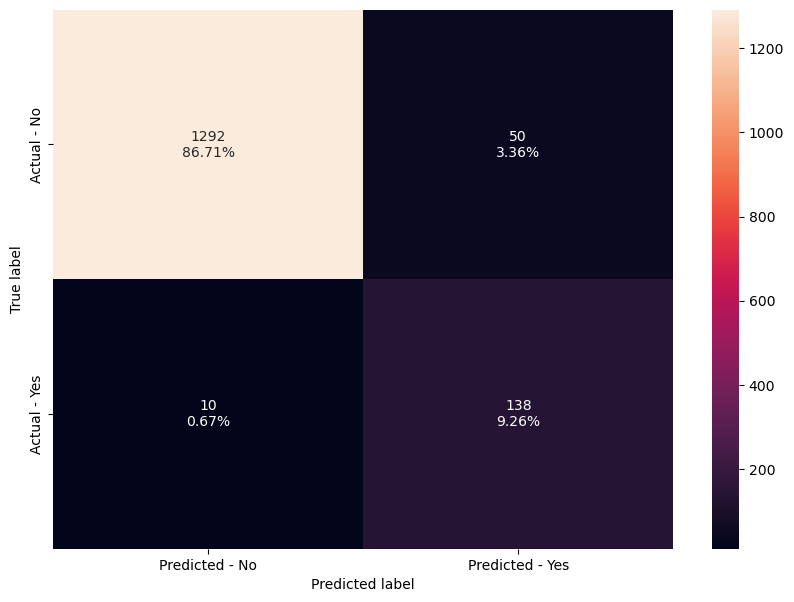

In [105]:
# Confusion matrix
make_confusion_matrix(dTree1, y_test)

In [106]:
# Accuracy on train and test
print("Accuracy on training set : ", dTree1.score(X_train, y_train))
print("Accuracy on test set : ", dTree1.score(X_test, y_test))


Accuracy on training set :  0.9568469505178366
Accuracy on test set :  0.959731543624161


In [107]:
# Recall on train and test
get_recall_score(dTree1)

Recall on training set :  0.9513677811550152
Recall on test set :  0.9324324324324325


In [108]:
# Precision on train and test
get_precision_score(dTree1)

Precision on training set :  0.7002237136465325
Precision on test set :  0.7340425531914894


In [109]:
# F1 score on train and test
get_f1_score(dTree1)

F1 score on training set :  0.8067010309278351
F1 score on test set :  0.8214285714285715


### Visualize the Decision Tree

In [110]:
feature_names = list(X.columns)
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'Local_Alameda', 'Local_Angeles', 'Local_Barbara', 'Local_Benito', 'Local_Bernardino', 'Local_Butte', 'Local_Clara', 'Local_Contra', 'Local_Cruz', 'Local_Diego', 'Local_Dorado', 'Local_Francisco', 'Local_Fresno', 'Local_Humboldt', 'Local_Imperial', 'Local_Joaquin', 'Local_Kern', 'Local_Lake', 'Local_Marin', 'Local_Mateo', 'Local_Mendocino', 'Local_Merced', 'Local_Monterey', 'Local_Napa', 'Local_Obispo', 'Local_Orange', 'Local_Placer', 'Local_Riverside', 'Local_Sacramento', 'Local_Shasta', 'Local_Siskiyou', 'Local_Solano', 'Local_Sonoma', 'Local_Stanislaus', 'Local_Trinity', 'Local_Tuolumne', 'Local_Ventura', 'Local_Yolo']


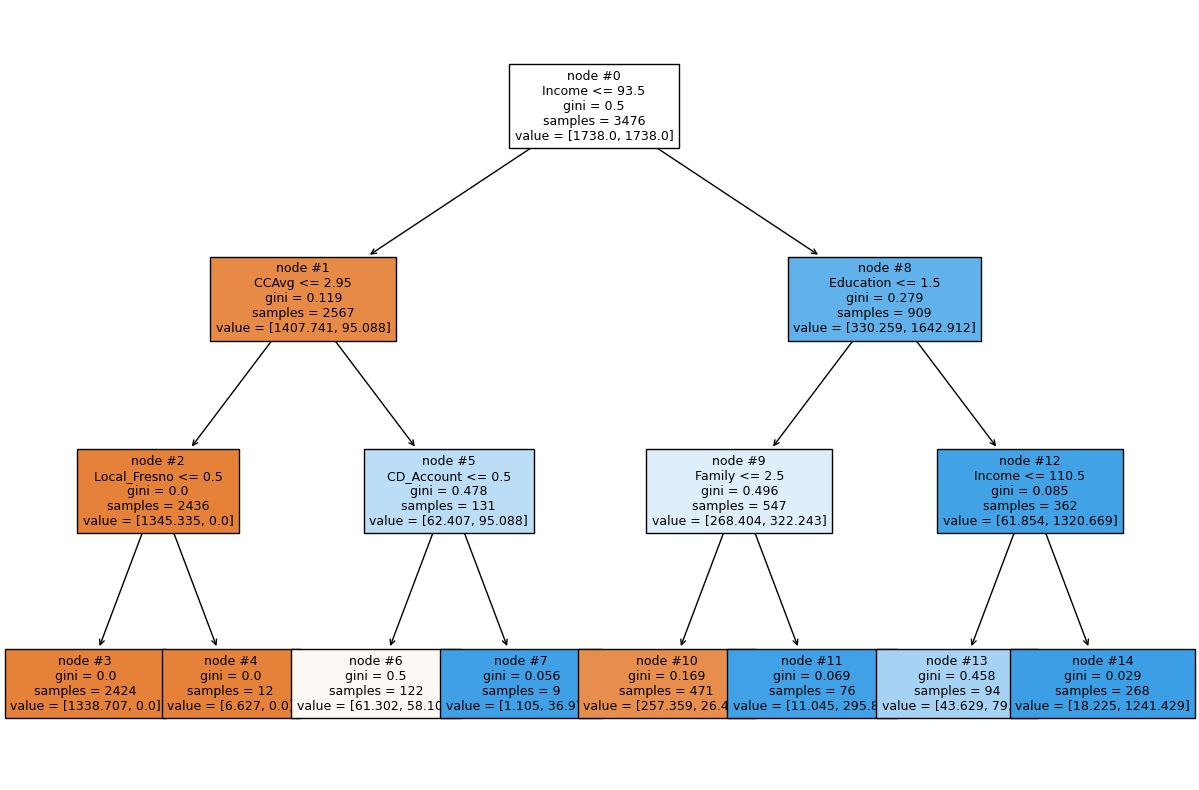

In [111]:
plt.figure(figsize=(15, 10))

tree.plot_tree(
    dTree1,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=None,
)
plt.show()

In [112]:
# Text report showing the decision tree rules

print(tree.export_text(dTree1, feature_names=feature_names, show_weights=True))

|--- Income <= 93.50
|   |--- CCAvg <= 2.95
|   |   |--- Local_Fresno <= 0.50
|   |   |   |--- weights: [1338.71, 0.00] class: 0
|   |   |--- Local_Fresno >  0.50
|   |   |   |--- weights: [6.63, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account <= 0.50
|   |   |   |--- weights: [61.30, 58.11] class: 0
|   |   |--- CD_Account >  0.50
|   |   |   |--- weights: [1.10, 36.98] class: 1
|--- Income >  93.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [257.36, 26.41] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [11.05, 295.83] class: 1
|   |--- Education >  1.50
|   |   |--- Income <= 110.50
|   |   |   |--- weights: [43.63, 79.24] class: 1
|   |   |--- Income >  110.50
|   |   |   |--- weights: [18.22, 1241.43] class: 1



In [113]:
# Importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        dTree1.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                             Imp
Income              6.838379e-01
Family              1.476538e-01
Education           9.170874e-02
CCAvg               6.785543e-02
CD_Account          8.944132e-03
Local_Fresno        2.958077e-16
Age                 0.000000e+00
Local_Placer        0.000000e+00
Local_Mateo         0.000000e+00
Local_Mendocino     0.000000e+00
Local_Merced        0.000000e+00
Local_Monterey      0.000000e+00
Local_Napa          0.000000e+00
Local_Obispo        0.000000e+00
Local_Orange        0.000000e+00
Local_Shasta        0.000000e+00
Local_Riverside     0.000000e+00
Local_Sacramento    0.000000e+00
Local_Lake          0.000000e+00
Local_Siskiyou      0.000000e+00
Local_Solano        0.000000e+00
Local_Sonoma        0.000000e+00
Local_Stanislaus    0.000000e+00
Local_Trinity       0.000000e+00
Local_Tuolumne      0.000000e+00
Local_Ventura       0.000000e+00
Local_Marin         0.000000e+00
Local_Imperial      0.000000e+00
Local_Kern          0.000000e+00
Local_Joaq

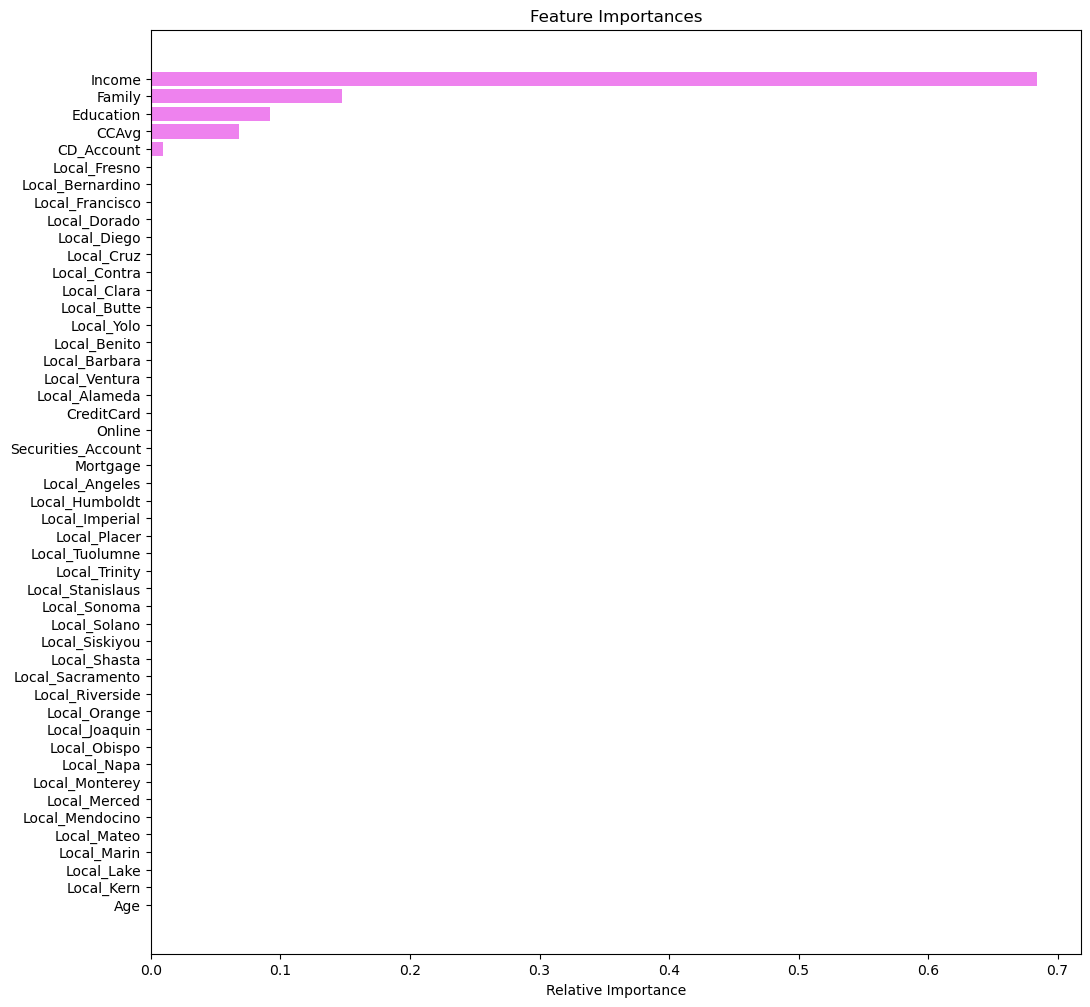

In [114]:
importances = dTree1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Use of gridsearch hyperparameter tuning may improve model results of the tree model and will be implemented below.

In [115]:
from sklearn.model_selection import GridSearchCV

In [116]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Grid of parameters to choose from
## add from article
parameters = {
    "max_depth": [3, 4, 8, None],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.000001, 0.00001, 0.01],
}


# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_impurity_decrease=0.01, random_state=1)

### Using GridSearch for Hyperparameter tuning of the tree model

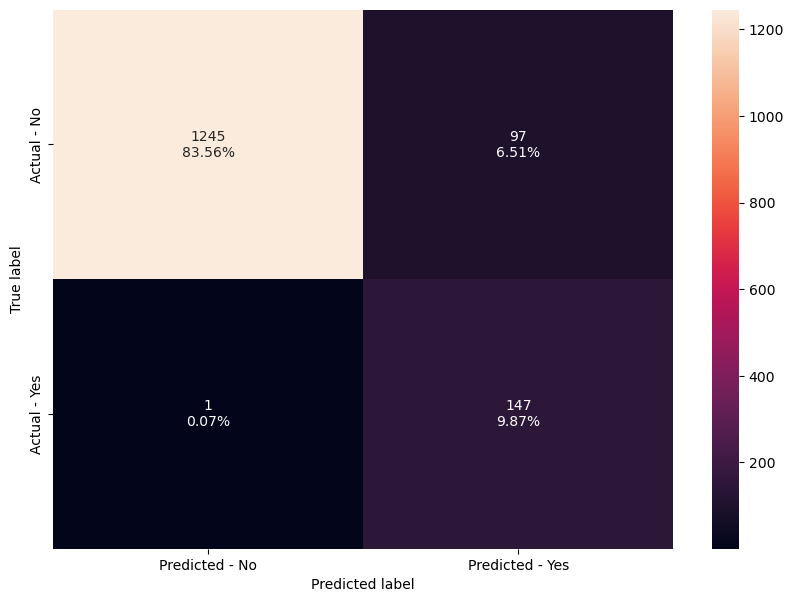

In [117]:
make_confusion_matrix(estimator, y_test)

In [118]:
# Accuracy on train and test
print("Accuracy on training set : ", estimator.score(X_train, y_train))
print("Accuracy on test set : ", estimator.score(X_test, y_test))

Accuracy on training set :  0.928078250863061
Accuracy on test set :  0.934228187919463


In [119]:
# Recall on train and test
get_recall_score(estimator)

Recall on training set :  0.9848024316109423
Recall on test set :  0.9932432432432432


In [120]:
# Precision on train and test
get_precision_score(estimator)

Precision on training set :  0.5694200351493849
Precision on test set :  0.6024590163934426


In [121]:
# F1 score on train and test
get_f1_score(estimator)

F1 score on training set :  0.7216035634743876
F1 score on test set :  0.75


### Visualizing the decision tree (hyperparameter pre- pruning)

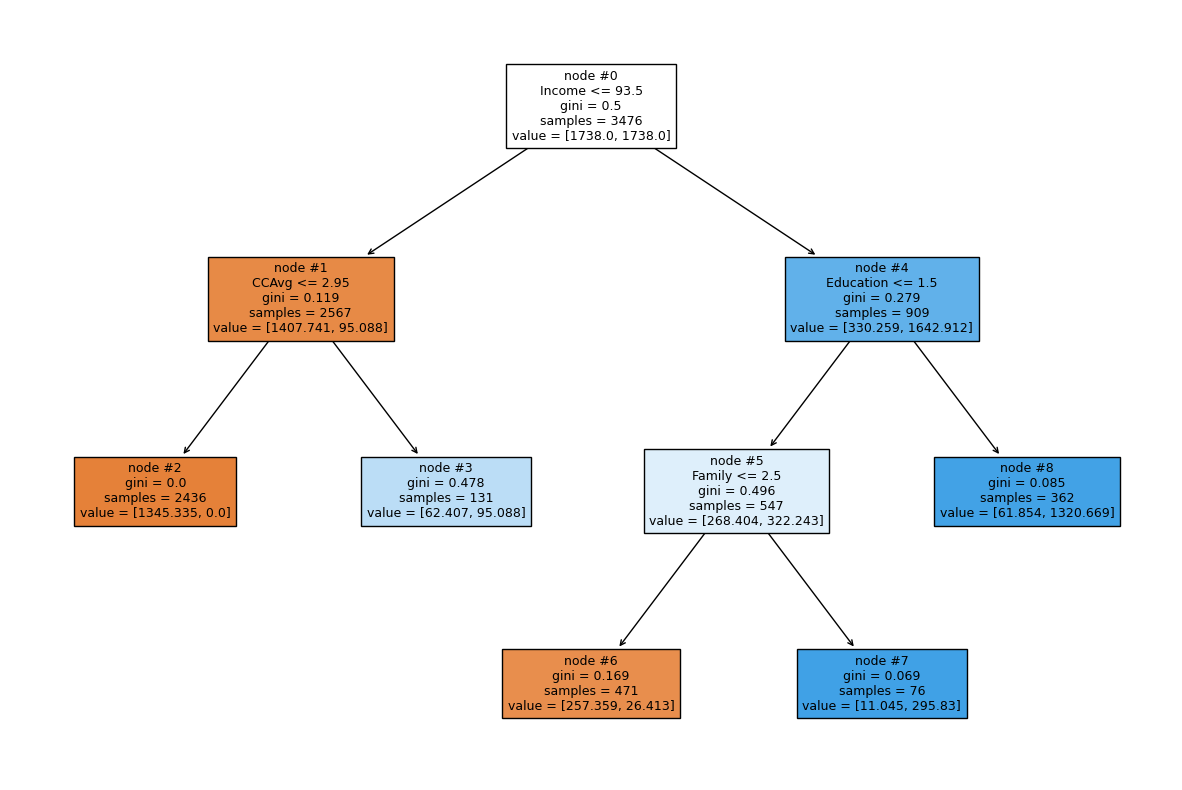

In [122]:
plt.figure(figsize=(15, 10))

tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=None,
)
plt.show()

In [123]:
# Text report showing the rules of a decision tree -

print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- Income <= 93.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1345.33, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- weights: [62.41, 95.09] class: 1
|--- Income >  93.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [257.36, 26.41] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [11.05, 295.83] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [61.85, 1320.67] class: 1



In [124]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        estimator.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

# Here we will see that importance of features has increased

                         Imp
Income              0.684551
Family              0.151610
Education           0.094166
CCAvg               0.069673
Age                 0.000000
Local_Placer        0.000000
Local_Marin         0.000000
Local_Mateo         0.000000
Local_Mendocino     0.000000
Local_Merced        0.000000
Local_Monterey      0.000000
Local_Napa          0.000000
Local_Obispo        0.000000
Local_Orange        0.000000
Local_Sacramento    0.000000
Local_Riverside     0.000000
Local_Kern          0.000000
Local_Shasta        0.000000
Local_Siskiyou      0.000000
Local_Solano        0.000000
Local_Sonoma        0.000000
Local_Stanislaus    0.000000
Local_Trinity       0.000000
Local_Tuolumne      0.000000
Local_Ventura       0.000000
Local_Lake          0.000000
Local_Imperial      0.000000
Local_Joaquin       0.000000
Local_Benito        0.000000
Mortgage            0.000000
Securities_Account  0.000000
CD_Account          0.000000
Online              0.000000
CreditCard    

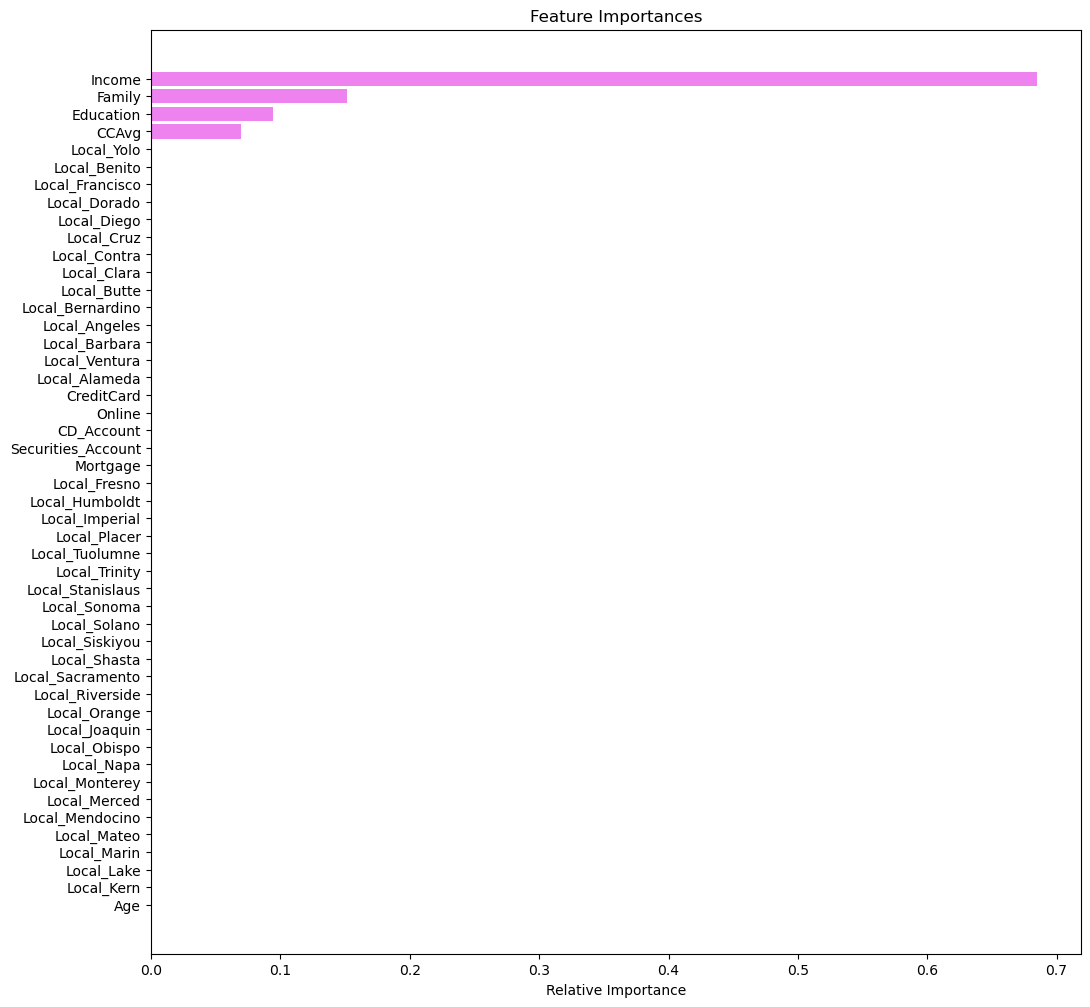

In [125]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Observations

- Use of grid search hyperparameter pre-pruning did result in an improved mode.  
- Further improvements my be possible by implementing post-pruning, which will be performed below.

### Evaluate post-pruning  (cost complexity pruning)

In [126]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [127]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.000184,0.000551
2,0.000247,0.001045
3,0.000264,0.001572
4,0.000281,0.002133
5,0.000283,0.002699
6,0.000341,0.003722
7,0.000345,0.004413
8,0.000345,0.005103
9,0.000351,0.005804


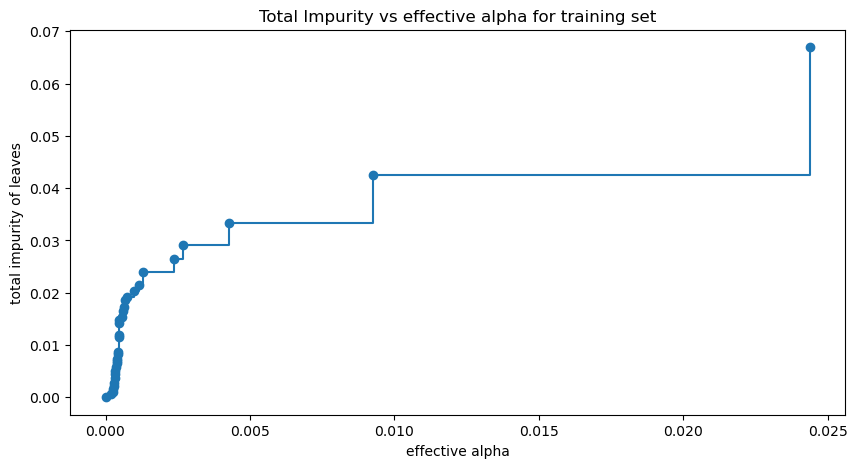

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

###Train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [129]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0522063548098257


### Remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. The number of nodes and tree depth decreases as alpha increases.

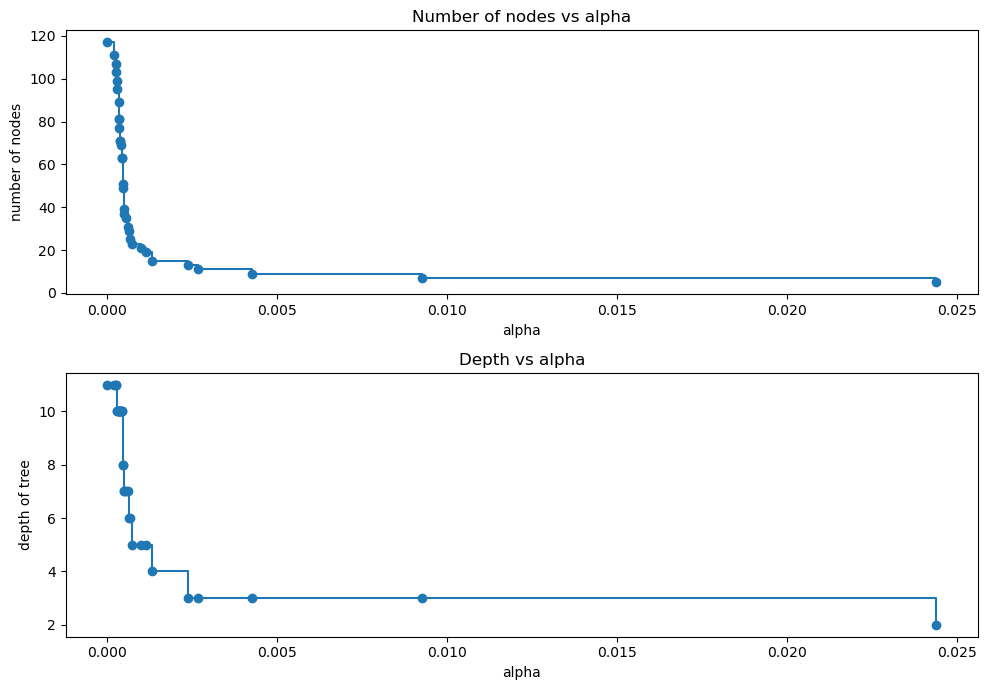

In [130]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Accuracy vs alpha for training and testing sets

### Observations

- When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading
  to a 100.0% training accuracy and 97.5% testing accuracy. 

- As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better.

In [131]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

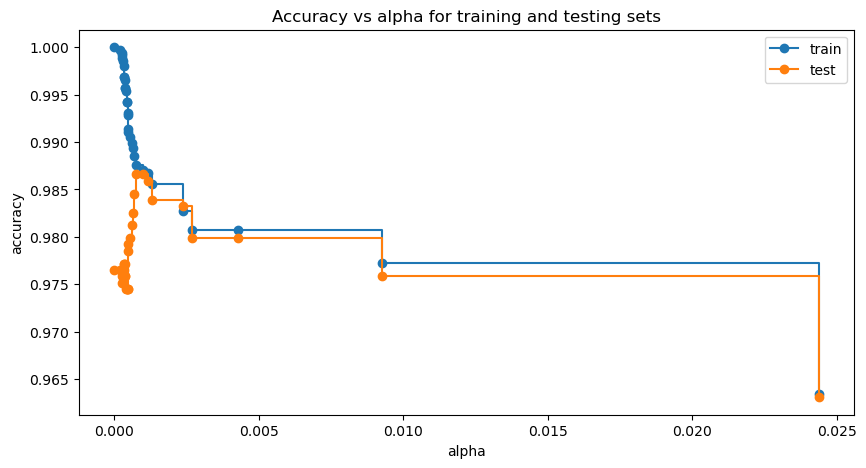

In [132]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [133]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)
print("Training accuracy of best model: ", best_model.score(X_train, y_train))
print("Test accuracy of best model: ", best_model.score(X_test, y_test))

DecisionTreeClassifier(ccp_alpha=0.0007310634265213565, random_state=1)
Training accuracy of best model:  0.9876294591484465
Test accuracy of best model:  0.9865771812080537


### Accuracy isn't the right metric for this data.  High recall is very desirable.

In [134]:
recall_train = []
for clf in clfs:
    pred_train3 = clf.predict(X_train)
    values_train = metrics.recall_score(y_train, pred_train3)
    recall_train.append(values_train)

In [135]:
recall_test = []
for clf in clfs:
    pred_test3 = clf.predict(X_test)
    values_test = metrics.recall_score(y_test, pred_test3)
    recall_test.append(values_test)

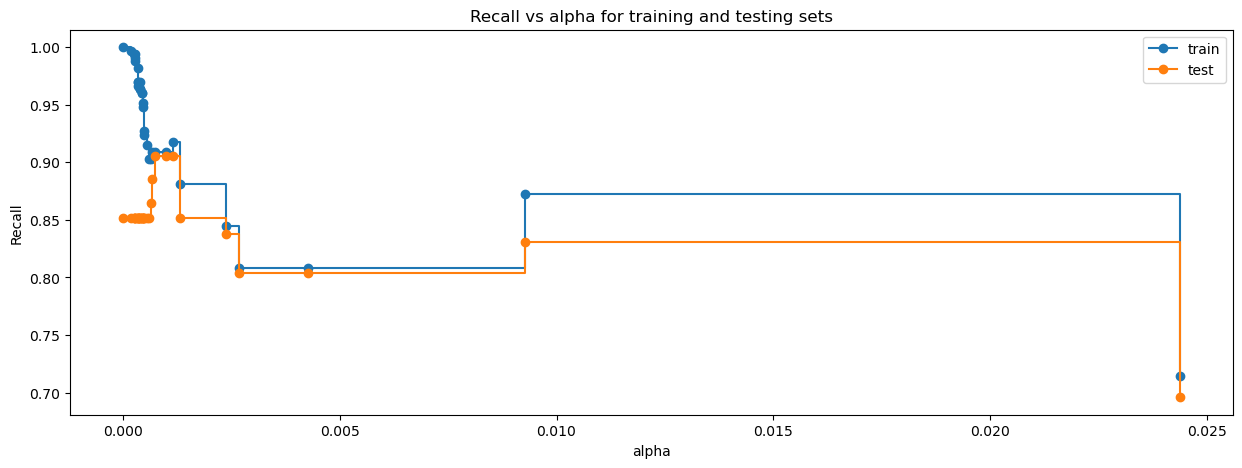

In [136]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [137]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0007310634265213565, random_state=1)


### Confusion Matrix - post-pruned decision tree

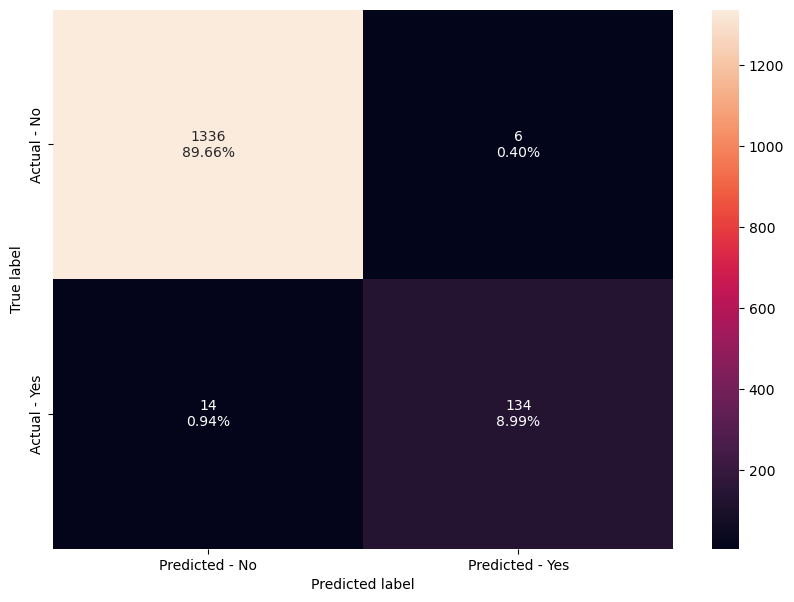

In [138]:
# Plot Confusion Matrix
make_confusion_matrix(best_model, y_test)

In [139]:
# Accuracy on train and test
print("Accuracy on training set : ", best_model.score(X_train, y_train))
print("Accuracy on test set : ", best_model.score(X_test, y_test))

Accuracy on training set :  0.9876294591484465
Accuracy on test set :  0.9865771812080537


In [140]:
# Recall on train and test
get_recall_score(best_model)

Recall on training set :  0.9088145896656535
Recall on test set :  0.9054054054054054


In [141]:
# Precision on train and test
get_precision_score(best_model)

Precision on training set :  0.9583333333333334
Precision on test set :  0.9571428571428572


In [142]:
# Precision on train and test
get_f1_score(best_model)

F1 score on training set :  0.9329173166926678
F1 score on test set :  0.9305555555555555


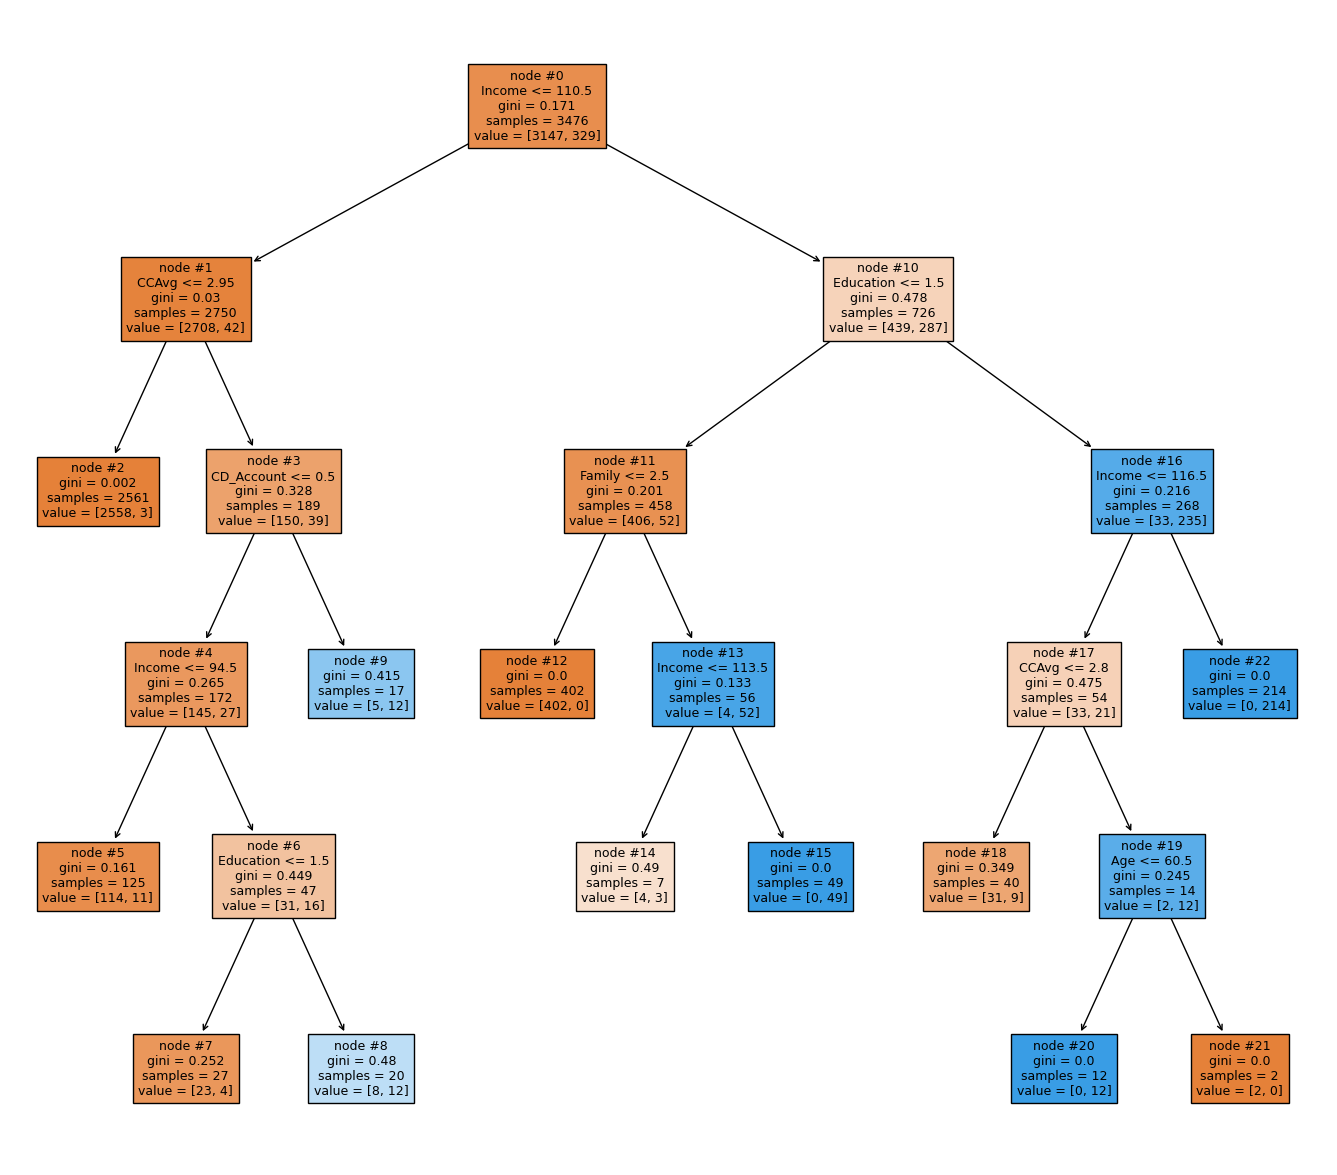

In [143]:
plt.figure(figsize=(17, 15))

tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=None,
)
plt.show()

In [144]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- Income <= 110.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [2558.00, 3.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account <= 0.50
|   |   |   |--- Income <= 94.50
|   |   |   |   |--- weights: [114.00, 11.00] class: 0
|   |   |   |--- Income >  94.50
|   |   |   |   |--- Education <= 1.50
|   |   |   |   |   |--- weights: [23.00, 4.00] class: 0
|   |   |   |   |--- Education >  1.50
|   |   |   |   |   |--- weights: [8.00, 12.00] class: 1
|   |   |--- CD_Account >  0.50
|   |   |   |--- weights: [5.00, 12.00] class: 1
|--- Income >  110.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [402.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- Income <= 113.50
|   |   |   |   |--- weights: [4.00, 3.00] class: 0
|   |   |   |--- Income >  113.50
|   |   |   |   |--- weights: [0.00, 49.00] class: 1
|   |--- Education >  1.50
|   |   |--- Income <= 116.50
|   |   |   |--- CCAvg <= 2.80
|   |   |   |   |--- weights: [31.00, 9.00]

In [145]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        best_model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                         Imp
Income              0.390451
Education           0.381448
Family              0.160291
CCAvg               0.043697
CD_Account          0.017629
Age                 0.006484
Local_Riverside     0.000000
Local_Mateo         0.000000
Local_Mendocino     0.000000
Local_Merced        0.000000
Local_Monterey      0.000000
Local_Napa          0.000000
Local_Obispo        0.000000
Local_Orange        0.000000
Local_Placer        0.000000
Local_Shasta        0.000000
Local_Sacramento    0.000000
Local_Lake          0.000000
Local_Siskiyou      0.000000
Local_Solano        0.000000
Local_Sonoma        0.000000
Local_Stanislaus    0.000000
Local_Trinity       0.000000
Local_Tuolumne      0.000000
Local_Ventura       0.000000
Local_Marin         0.000000
Local_Imperial      0.000000
Local_Kern          0.000000
Local_Bernardino    0.000000
Mortgage            0.000000
Securities_Account  0.000000
Online              0.000000
CreditCard          0.000000
Local_Alameda 

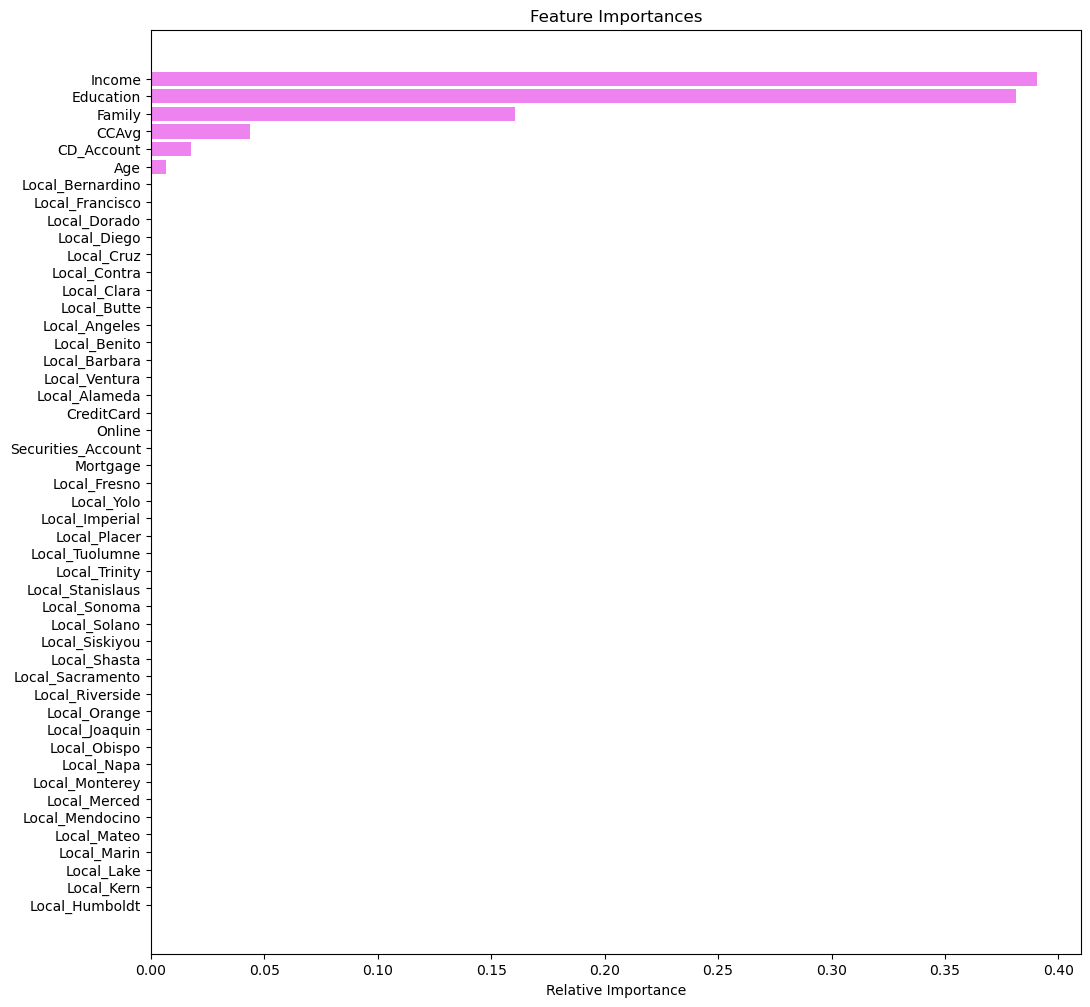

In [146]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Comparison of Decision Tree model performance for training set 

In [155]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "Decision Tree model no pruning",
            "Decision Tree with restricted maximum depth",
            "Decision Tree with gridsearch hyperparameter tuning",
            "Decision Tree with post-pruning",
        ],
        "Train_Accuracy": [1.0000, 0.9568, 0.9281, 0.9876],
        "Train_Recall": [1.0000, 0.9514, 0.9848, 0.9088],
        "Train_Precision": [1.0000, 0.7002, 0.5694, 0.9583],
        "Train_F1": [1.0000, 0.8067, 0.7216, 0.9329],
    }
)
comparison_frame

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1
0,Decision Tree model no pruning,1.0000,1.0000,1.0000,1.0000
1,Decision Tree with restricted maximum depth,0.9568,0.9514,0.7002,0.8067
2,Decision Tree with gridsearch hyperparameter tuning,0.9281,0.9848,0.5694,0.7216
3,Decision Tree with post-pruning,0.9876,0.9088,0.9583,0.9329


### Observations

- The Decision Tree model with no pruning is over trained.
- The Decision Tree with gridsearch hyperparameter tuning has the greatest recall (0.9848) of any of the models that are not
  overtrained.
- The Decision Tree with gridsearch hyperparameter tuning has the lowest precision and F1-score of any of the models.



### Comparison of Decision Tree model performance for test set 

In [156]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "Decision Tree model no pruning",
            "Decision Tree with restricted maximum depth",
            "Decision Treee with gridsearch hyperparameter tuning",
            "Decision Tree with post-pruning",
        ],
        "Test_Accuracy": [0.9745, 0.9597, 0.9342, 0.9866],
        "Test_Recall": [0.8649, 0.9324, 0.9932, 0.9054],
        "Test_Precision": [0.8767, 0.7340, 0.6025, 0.9571],
        "Test_F1": [0.8707, 0.8214, 0.7500, 0.9306],
    }
)
comparison_frame

,Model,Test_Accuracy,Test_Recall,Test_Precision,Test_F1
0,Decision Tree model no pruning,0.9745,0.8649,0.8767,0.8707
1,Decision Tree with restricted maximum depth,0.9597,0.9324,0.7340,0.8214
2,Decision Treee with gridsearch hyperparameter tuning,0.9342,0.9932,0.6025,0.7500
3,Decision Tree with post-pruning,0.9866,0.9054,0.9571,0.9306


### Observations

- The Decision Tree model with no pruning recall is lowest due to over training on the training data.
- The Decision Tree with gridsearch hyperparameter tuning has the greatest recall (0.9932) of any of the models.
- The Decision Tree with gridsearch hyperparameter tuning has the lowest precision and F1-score of any of the models.

### Comparison Of Training Preformance For All Models

In [150]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "Logistic Regression with default threshold",
            "Logistic Regression with optimum AUC-ROC threshold",
            "Logistic Regression with optimum Precision Recall threshold",
            "Decision Tree model with no pruning",
            "Decision Tree with restricted maximum depth",
            "Decision Treee with gridsearch hyperparameter tuning",
            "Decision Tree with post-pruning"
        ],
        "Train_Accuracy": [0.9540, 0.8979, 0.9491, 1.0000, 0.9568, 0.9281, 0.9876],
        "Train_Recall": [0.6413, 0.9027, 0.7295, 1.0000, 0.9514, 0.9848, 0.9088],
        "Train_Precision": [0.8340, 0.4790, 0.7317, 1.0000, 0.7002, 0.5694, 0.9583],
        "Train_F1": [0.7251, 0.6259, 0.7306, 1.0000, 0.8067, 0.7216, 0.9329]
    }
)
comparison_frame

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1
0,Logistic Regression with default threshold,0.9540,0.6413,0.8340,0.7251
1,Logistic Regression with optimum AUC-ROC threshold,0.8979,0.9027,0.4790,0.6259
2,Logistic Regression with optimum Precision Recall threshold,0.9491,0.7295,0.7317,0.7306
3,Decision Tree model with no pruning,1.0000,1.0000,1.0000,1.0000
4,Decision Tree with restricted maximum depth,0.9568,0.9514,0.7002,0.8067
5,Decision Treee with gridsearch hyperparameter tuning,0.9281,0.9848,0.5694,0.7216
6,Decision Tree with post-pruning,0.9876,0.9088,0.9583,0.9329


### Observations

- The training recall for all Logistic Regression Models were all lower than all of the Decision Tree models.
- The only model which overtrained on the training data was the Decision Tree with no pruning.
- The Decision Tree with gridsearch hyperparameter tuning had the greatest recall (0.9848) and lowest training precision.

### Comparison Of Testing Preformance For All Models

In [151]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "Logistic Regression with default threshold",
            "Logistic Regression with optimum AUC-ROC threshold",
            "Logistic Regression with optimum Precision Recall threshold",
            "Decision Tree model with no pruning",
            "Decision Tree with restricted maximum depth",
            "Decision Treee with gridsearch hyperparameter tuning",
            "Decision Tree with post-pruning"
        ],
        "Test_Accuracy": [0.9490, 0.8913, 0.9477, 0.9745, 0.9597, 0.9342, 0.9866],
        "Test_Recall": [0.6284, 0.8784, 0.7095, 0.8649, 0.9324, 0.9932, 0.9054],
        "Test_Precision": [0.8158, 0.4745, 0.7500, 0.8767, 0.7340, 0.6025, 0.9571],
        "Test_F1": [0.7100, 0.6161, 0.7292, 0.8707, 0.8214, 0.7500, 0.9306]
    }
)
comparison_frame

,Model,Test_Accuracy,Test_Recall,Test_Precision,Test_F1
0,Logistic Regression with default threshold,0.9490,0.6284,0.8158,0.7100
1,Logistic Regression with optimum AUC-ROC threshold,0.8913,0.8784,0.4745,0.6161
2,Logistic Regression with optimum Precision Recall threshold,0.9477,0.7095,0.7500,0.7292
3,Decision Tree model with no pruning,0.9745,0.8649,0.8767,0.8707
4,Decision Tree with restricted maximum depth,0.9597,0.9324,0.7340,0.8214
5,Decision Treee with gridsearch hyperparameter tuning,0.9342,0.9932,0.6025,0.7500
6,Decision Tree with post-pruning,0.9866,0.9054,0.9571,0.9306


### Observations On Testing Performance For All Models

- The Decision Tree with gridsearch hyperparameter tuning testing recall is 0.9932 which is the greatest of any model.  Recall
  is the key parameter for model evaluation because of the comparatively high cost for false negatives due to the opportunity
  cost for not identifying customers who will take loans. Using any of the models with lower recall would result in a high
  opportunity cost. 
  
- The testing F1 for the Decision Tree with gridsearch hyperparameter tuning testing is 0.7500 which is the median value for
  all model F1 scores. The precision is 0.6025. The precision is comparatively low, however, this is not a significant concern
  as there is very little cost involved in soliciting customers for loans, even those who do not take a loan.
  
- The Decision Tree with depth limited to a maximum depth of 3 had the second highest recall (0.9324) and higher precision and
  F1 than the Decision Tree with gridsearch hyperparameter. This model is not recommended to be used due to the opportunity
  cost associated with lower recall.

- Using the optimum AUC-ROC threshold provided the best recall (0.8784) for the Logistics Regression models. This model had a
  greater recall than the other two Logistic Regression models, however, using this model would result in more false negatives
  than the recommended Decision Tree model. 


### Business Findings and Actionable  Recommendations


- The bank should deploy this predictive model to identify customers who will be interested in taking a personal loan.

- These factors have an impact on Personal_Loan: Income, Family, Education.

- Higher income customers should be the target customers for the bank - Customers who have income above 116k dollars and a
  family of more than 2, such customers have higher chances of taking personal loans.

- The bank should target customers with a higher education (education level greater than undergraduate) as the probability of
  these cusomers taking a loan is higher.

- Size of the family has a positive correlation with the personal loan, as the size of the family increases (generally a family
  size of 3 or more than 3 members) have more chances of a customer taking a personal loan.

- The data indicates that ~50% of the customers who have the certificate of deposit with the bank (CD_Account) are the ones
  that have a requirement for a personal loan. The bank should target such customers.